Hi, everyone!
I want to show how [**Iris Dataset encoded by Gaussian receptive fields**](https://www.kaggle.com/datasets/patrickstarrrr/iris-dataset-encoded-by-gaussian-receptive-fields) can be used. To do this, we will write from scratch using only NumPy and a little bit Pandas the LIF model of a neuron, which will solve the classification problem with an accuracy of 100%. This notebook repeats introduction  and the second part of the [**SNN & Gaussian receptive fields|Test accuracy 100%**](https://www.kaggle.com/code/patrickstarrrr/snn-gaussian-receptive-fields-test-accuracy-100) with minor changes.

Let's get started!

In general, our simplest network will have the following architecture:

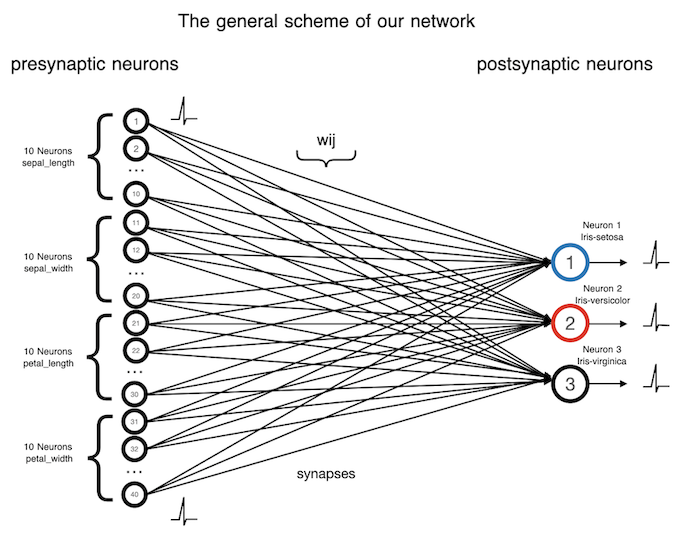

The dataset contains three types of flowers: Versicolor, Setosa, and Virginica.
Each class contains 4 features: "Sepal Length", "Sepal Width", "Petal Length", "Petal Width".
The goal of iris flower classification is to predict the flower types based on their specific features.
We will encode the values of each feature using 10 presynaptic neurons, for a total of 40 neurons.
In the output layer, we will have 3 postsynaptic neurons for each type of flower.

But how does it work?
Neurons are connected to each other by synapses with a certain weight, and tuning these weights is our main task, which we will solve below. The main essence of the model: presynaptic neurons (input information) generate spikes that stimulate postsynaptic neurons -> membrane potential (Vm) of postsynaptic neurins is rising -> postsynaptic neurons generate their spikes from this (output information). The postsynaptic neuron that fires first on a given input layer (period 10ms) is the predicted type of color that our impulse network.

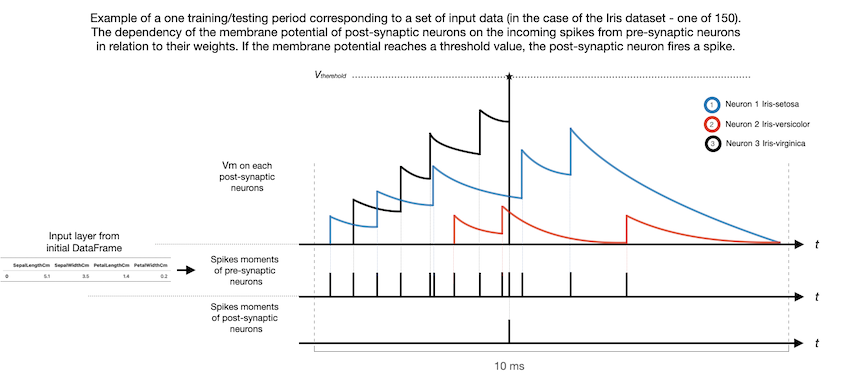

Now let's go over it again, but in a bit more detail, and then we can start writing the code.

The change in the postsynaptic neuron's membrane potential depends on the timing of spikes from presynaptic neurons and the weight of the synapse between them. If there are no spikes coming from the presynaptic neurons, the postsynaptic neuron's membrane potential tends towards the resting potential (in our case, this is 0). The spike itself is an elementary event in the universe of SNN.

When the membrane potential of postsynaptic neuron reaches a threshold value, the postsynaptic neuron fires a spike. All of this happens during each training and testing period, which we take to be 10ms - the training period being the time during which all **active** presynaptic neurons corresponding to the values of the four input data features generate their spikes (there are a total of 150 such periods in the dataset). The postsynaptic neuron can either generate a spike or not. The postsynaptic neuron that fires a spike before any of the other postsynaptic neurons is considered to have fired during that period, while the others have not. After generating a spike, the postsynaptic neuron's potential falls back to the resting potential and does not change again until the end of the current training period (it cannot fire more than once on a single set of input data).

Great! We've covered all the basics. Now let's move on to the first part, which is encoding the original dataset to obtain the spike timing of the presynaptic neurons, or rather their latency.

Import all the necessary packages for work:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

Load the dataset:

In [2]:
URL = '/kaggle/input/iris-dataset-encoded-by-gaussian-receptive-fields/Iris_Dataset_encoded_by_Gaussian_receptive_fields_for_SNN.csv'

Final_df = pd.read_csv(URL)
Final_df = Final_df.iloc[:,1:]

Let's move on to training our LIF neuron!

Before we write our own LIF neuron model, it is important to understand how synapse weights are formed, which I described at the beginning of this notebook. After we split our dataset into training (size of 120 out of 150: 40 for each flower type) and testing sets, we will train our model by adjusting the weights of synaptic connections. To do this, we will divide the training into two parts.

Part one. Subsample size of 60: the first 20 values for each flower type.

The data in the original data set are distributed sequentially by iris types: a total of 150 data sets of which the first 50 records belong to Iris-setosa, 50-100 - Iris-versicolor, 100-150 - Iris-virginica. I writen a function that will select the data set we need from the portfolio, in which there will be an equal number of instances of each type:

In [3]:
def model_data(ind, ind_type, lat_ne, start, end):
    
    train_stack = np.vstack((lat_ne[ind_type[ind, 0] + start:ind_type[ind, 0] + end],
                            lat_ne[ind_type[ind, 1] + start:ind_type[ind, 1] + end],
                            lat_ne[ind_type[ind, 2] + start:ind_type[ind, 2] + end]))
    train_stack = np.where(train_stack > 0, train_stack, 0)
    
    return train_stack

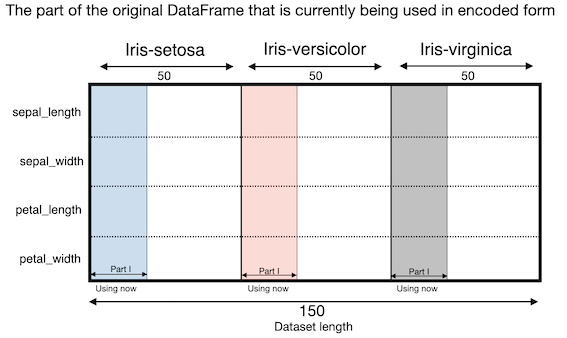

At the first stage, we need to somehow increase the weights of active synapses, forming a set of weights for each postsynaptic neuron for further correction using STDP (Spike-timing-dependent plasticity) at the second stage. How can we do this? There can be many options, here are the basic principles of weight gain that I will use for the first part of the training set:
1. All weights are initially equal to 0.1
2. For each postsynaptic neuron in the training period **corresponding to its flower type**, we increase the weights of all active presynaptic neurons by a constant that is the same for all, adjusted depending on the delay of the specific presynaptic neuron: less delay -> presynaptic neuron generated a spike earlier -> receives a greater weight. The general formula is as follows: delta_weight = +Const * (1 - latency)
3. For each postsynaptic neuron in the training period **not corresponding to its flower type**, we impose a penalty on all active presynaptic neurons that have a weight that is not the default (weight > 0.1). That is, we "penalize" presynaptic neurons that fire for different types of flowers, reducing their weights -> reducing their contribution to the stimulation of the membrane potential of postsynaptic neurons of other flower types. Similarly to point 2, the size of the penalty is equal to the same constant, adjusted for the delay of the active neuron in this training period. The general formula is as follows: delta_weight = -Const * (1 - latency)
4. The "penalty" from point 3 is evenly distributed among non-active presynaptic neurons in this period that have a weight that is not the default (weight > 0.1). The general formula is as follows: delta_weight = -Const * (1 - latency) / N, where latency is the delay of the fired presynaptic neuron, N is the number of "silent" presynaptic neurons with a weight greater than the default
5. Adjusted weights cannot be less than the default value: if the weight decreases, then 0.1 is the lower limit. We **do not have "braking"** presynaptic neurons with negative connection weights
6. In each iteration (each period), connections with default weights are not corrected in any way

Phew! If I confused you a little, the picture below will help you understand:

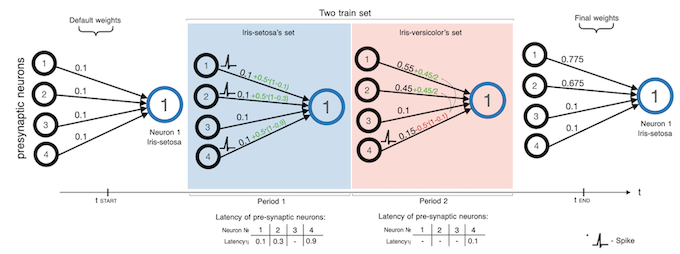

In [4]:
lat_ne = np.transpose(Final_df.values)
ind_type = np.array(([0, 50, 100], [50, 100, 0], [100, 0, 50]))
list_weight = np.zeros((3,40))

for ind in range(3):
    
    train_stack = model_data(ind, ind_type, lat_ne, 0, 20)
    tr_ar = np.where(np.transpose(train_stack) > 0, 2 * (1 - np.transpose(train_stack)), 0)
    tr_ar[:, 20:] = tr_ar[:, 20:] * (-1)
    tr_ar = pd.DataFrame(tr_ar)
    tr_ar[20] = tr_ar.iloc[:,:20].sum(axis = 1) + 0.1
    tst_ar = np.float64(np.transpose(np.array(tr_ar.iloc[:,20:])))
    
    for i in range(1, len(tst_ar)):
        
        tst_ar[0][((np.round(tst_ar[0], 4) > 0.1) & (tst_ar[i] == 0))] += - np.float64(
            np.sum(tst_ar[i][np.round(tst_ar[0], 4) > 0.1]) / len(tst_ar[0][((
                np.round(tst_ar[0], 4) > 0.1) & (tst_ar[i] == 0))]))
        tst_ar[0][np.round(tst_ar[0], 4) > 0.1] += tst_ar[i][np.round(tst_ar[0], 4) > 0.1]
        tst_ar[0][tst_ar[0] < 0.1] = 0.1
        
    list_weight[ind, :] = tst_ar[0]

list_weight

array([[ 6.32765134,  9.87105956,  8.84511981,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         2.92858219,  7.46764082,  9.63385354,  3.93701917,  5.11459003,
         9.28614898, 24.82172975,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        22.32748549, 20.18358506,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ],
       [ 0.1       ,  0.1       ,  0.1       ,  7.07935274,  3.98891031,
         4.65097619,  4.98755772,  0.1       ,  0.1       ,  0.1       ,
         8.02471674, 10.06988848,  0.1       ,  3.97558974,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  6.75899905, 12.65014928,
        17.92551459,  0.1       ,  0.1       ,  0.

We have obtained our first set of weights! Let's write a function for our neuron that takes into account the synaptic weights and spike timings of presynaptic neurons. Then we will see how the membrane potential of each postsynaptic neuron behaves.

But first, let's introduce the formula for changing the membrane potential of a postsynaptic neuron. Simply put: a spike with the weight of the synapse arrives at the postsynaptic neuron -> the membrane potential of the postsynaptic neuron increases, and if no spikes arrive, the potential drops to its minimum level (in our case, this is 0) - this logic is visible in the following formula:

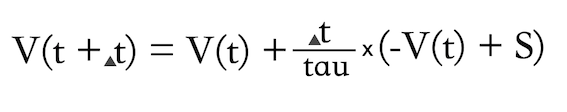

this formula is a slightly modified and simplified version of formula from [10], but all the logic of the classic LIF neuron is preserved here. In my formula, the resting potential is absent because I assume it to be equal to 0. Input parameters such as tau, dt, Vmin can be chosen to approximate the model to the biological neuron model. In this case, I do not have such a task, so the parameters are chosen to be as clear and functional as possible. Now let's implement this logic in code:

In [5]:
def LIF_SNN(n, l, data, weight, v_spike):
    
    V_min = 0
    V_spike = v_spike
    r = 5
    tau = 2.5
    dt = 0.01
    t_max = 10
    time_stamps = t_max / dt
    time_relax = 10
    v = np.zeros((n, l, int(time_stamps)))
    t_post = np.zeros((n, l))
    t_post_ = np.zeros((n, int(l / 3)))
    v[:, :, 0] = V_min
    
    for n in range(n):
        for u in range(l):
            
            t = 0
            f0 = (np.round(data[u][np.newaxis].T, 3) * 1000).astype(int)
            f1 = np.tile(np.arange(1000), (40, 1))
            f2 = np.where(((f1 == f0) & (f0 > 0)), 1, 0)
            f2 = f2 * weight[n][np.newaxis].T
            spike_list = np.sum(f2.copy(), axis = 0)

            for step in range(int(time_stamps) - 1):
                if v[n, u, step] > V_spike:
                    t_post[n, u] = step
                    v[n, u, step] = 0
                    t = time_relax / dt
                elif t > 0:
                    v[n, u, step] = 0
                    t = t - 1

                v[n, u, step + 1] = v[n, u, step] + dt / tau * (-v[n, u, step] + r * spike_list[step])
        t_post_[n, :] = t_post[n, n * int(l / 3):n * int(l / 3) + int(l / 3)]
    
    return v, t_post_, t_post

Function for visualizing spike moments of postsynaptic neurons:

In [6]:
def spike_plot(spike_times, one_per, n, cur_type):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 10))
    
    if one_per:
        k, t, a  = 1, n, 0
        cur = cur_type
    else:
        k, t, a = len(spike_times[0]), 0, 1
        cur = 1
        
    spike_times[spike_times == 0] = np.nan
    di = {0: 'blue', 1: 'red', 2: 'black'}
    di_t = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    p = 0
    
    for ax in [ax1, ax2, ax3]:
        for i in range(k * t, k + t):
            ax.vlines(x = spike_times[p, i] / 100 + i * a * 10, ymin = 0.0, ymax = 1.1, 
                       colors = di[p], ls = '-', lw = 3)
            ax.set_ylabel(f'Neuron {p + 1} \n {di_t[p]}', fontsize = 15)
            
        if one_per:
            ax.axvspan(0, int(k * 10), color = di[cur - 1], alpha = 0.05, label = di_t[cur - 1])
            ax.margins(0)
        else:
            ax.axvspan(0, int(k * 10 / 3), color = di[0], alpha = 0.05, label = di_t[0])
            ax.axvspan(int(k * 10 / 3), int(k * 10 * 2 / 3), color = di[1], alpha = 0.05, label = di_t[1])
            ax.axvspan(int(k * 10 * 2 / 3), int(k * 10 * 3 / 3), color = di[2], alpha = 0.05, label = di_t[2])
            ax.set_xlim(0, k * 10)
            ax.margins(0)
            
        p += 1
        
    
    if one_per:
        plt.suptitle(f' \n\n Moment of spike of postsynaptic neurons for train period {n}', fontsize = 20)
        plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 1.9), loc = 'upper left',
               fontsize = 15, title_fontsize = 15)
    else:
        plt.suptitle(f' \n\n Moment of spike of postsynaptic neurons on the used part of the dataset', fontsize = 20)
        plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 2.1), loc = 'upper left',
               fontsize = 15, title_fontsize = 15)
    
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.show()

Function for visualizing membrane potential of each postsynaptic neuron:

In [7]:
def v_plot(v):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 10))
    k = len(v[0,:,:])
    di = {0: 'blue', 1: 'red', 2: 'black'}
    di_t = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}
    p = 0
    
    for ax in [ax1, ax2, ax3]:
        for i in range(k):
            ax.plot(np.arange(i * 10, (i + 1) * 10, 0.01), v[p, i, :], di[p], linewidth = 1)
            ax.set_ylabel(f' Neuron {p + 1} \n {di_t[p]} \nV (mV)', fontsize = 15)

        ax.axvspan(0, int(k * 10 / 3), color = di[0], alpha = 0.05, label = di_t[0])
        ax.axvspan(int(k * 10 / 3), int(k * 10 * 2 / 3), color = di[1], alpha = 0.05, label = di_t[1])
        ax.axvspan(int(k * 10 * 2 / 3), int(k * 10 * 3 / 3), color = di[2], alpha = 0.05, label = di_t[2])
        ax.margins(0)

        p += 1
    
    plt.legend(title = "    Part of a type set:" ,bbox_to_anchor = (1, 2), loc = 'upper left', fontsize = 15, title_fontsize = 15)
    plt.xlabel('Time (ms)', fontsize = 15)
    plt.suptitle(' \n Activity of postsynaptic neurons on the used part of the dataset \n (Membrane potential)', fontsize = 20)

Accuracy function. If multiple postsynaptic neurons generate spikes during one period, the postsynaptic neuron that generated the spike first is considered to have fired:

In [8]:
def accuracy_snn(spike_time, start, end, ind_type, ind):
    
    target_type_total = np.repeat(np.array([1,2,3]),50)
    target_type = np.vstack((target_type_total[ind_type[ind, 0] + start:ind_type[ind, 0] + end],
                            target_type_total[ind_type[ind, 1] + start:ind_type[ind, 1] + end],
                            target_type_total[ind_type[ind, 2] + start:ind_type[ind, 2] + end])).flatten()
    
    spike_time_ = np.where(spike_time > 0, np.array(([1], [2], [3])), np.nan)
    final_test = np.full([len(spike_time[0])], np.nan).astype(int)
    for i in range(len(spike_time[0])):
        try:
            final_test[i] = spike_time_[:, i][spike_time[:, i] == np.min(spike_time[:, i][spike_time[:, i] > 0])][0]
        except:
            final_test[i] = 0
    
    ac = np.sum(np.where(final_test == target_type, 1, 0)) / len(target_type)

    return final_test, target_type, print('accur.:', np.round(ac * 100, 2), '%')

We adjusted and increased the weights on the first 20 instances of each type for each postsynaptic neuron, resulting in three sets of weights. Let's examine the membrane potential profile of each postsynaptic neuron with these obtained weights on the same first part of the training set. At this stage, we will not limit the membrane potential to a threshold level, choosing it to be equal to 100:

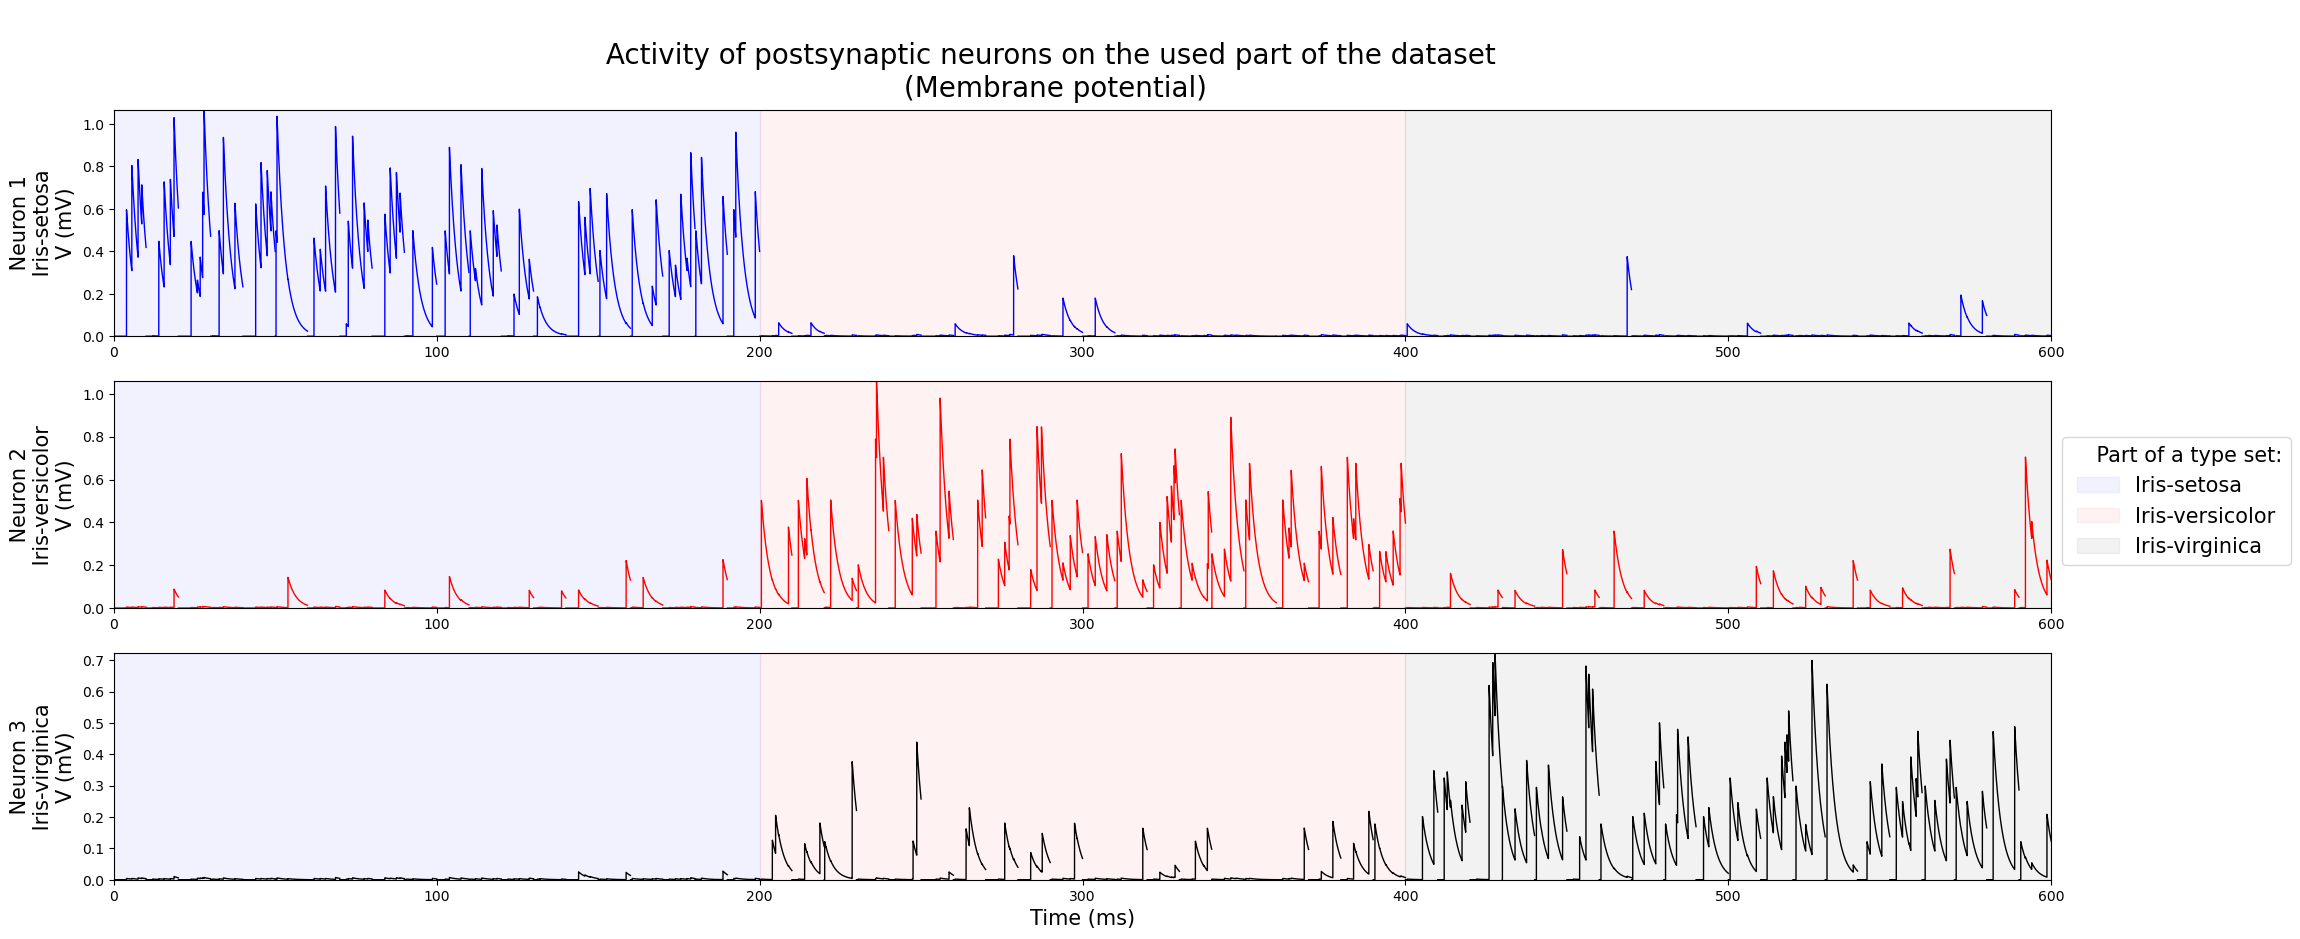

In [9]:
train_stack = model_data(0, ind_type, lat_ne, 0, 20)
res = LIF_SNN(3, 60, train_stack, list_weight, 100)
v = res[0]

v_plot(v)

Overall, it looks good, with each postsynaptic neuron's activity area clearly visible. The membrane potential profile of the first neuron looks the best, while neurons 2 and 3 are more responsive to "foreign" spikes that should not significantly change their potentials - this could lead to incorrect classification. Let's look at the spike times and accuracy at this stage with a threshold voltage value of 0.25:

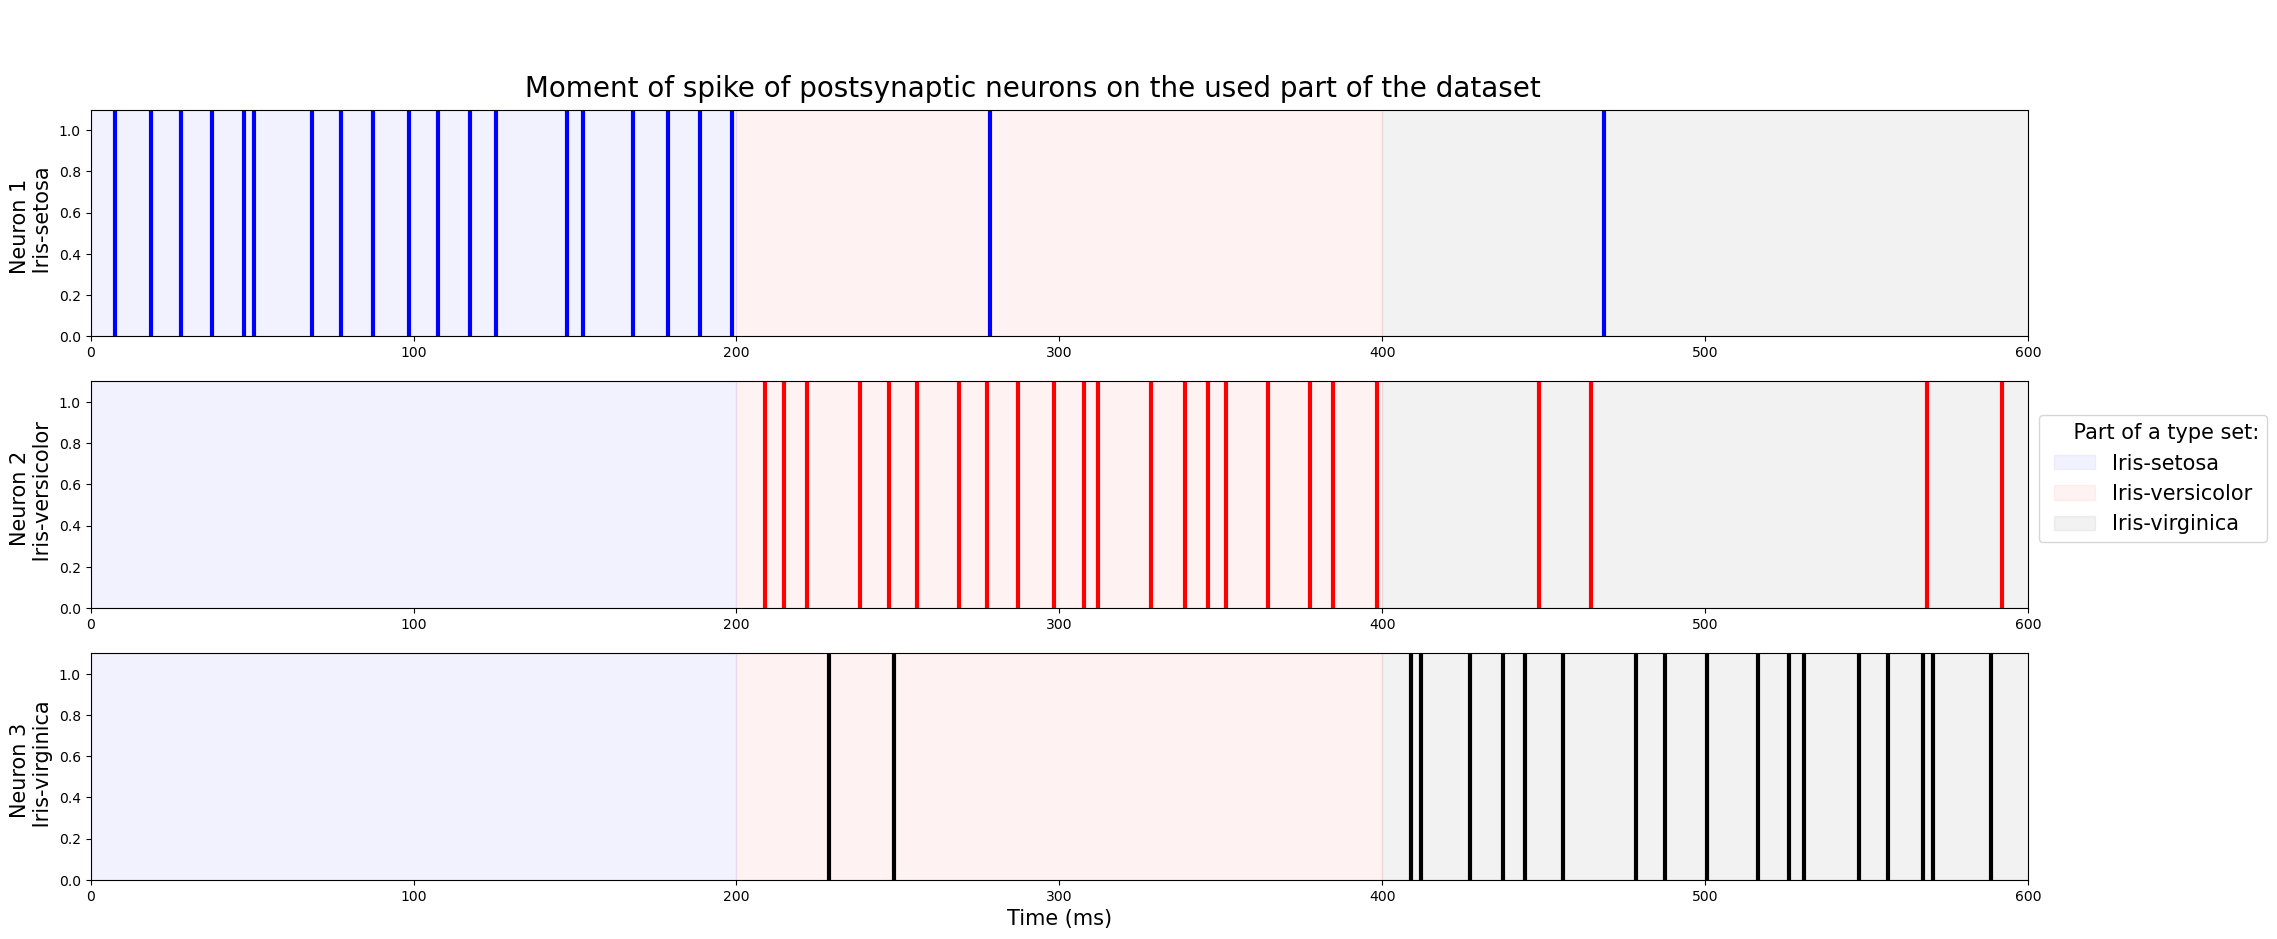

accur.: 93.33 %


In [10]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 0, 20, ind_type, 0)[2]


The accuracy is good! Let's examine a few periods where one of the postsynaptic neurons has false activations. We'll try to understand what's happening and how it affects accuracy.

Let's look at the last false spike of the first postsynaptic neuron, which occurs in period 46 of the first part of training:

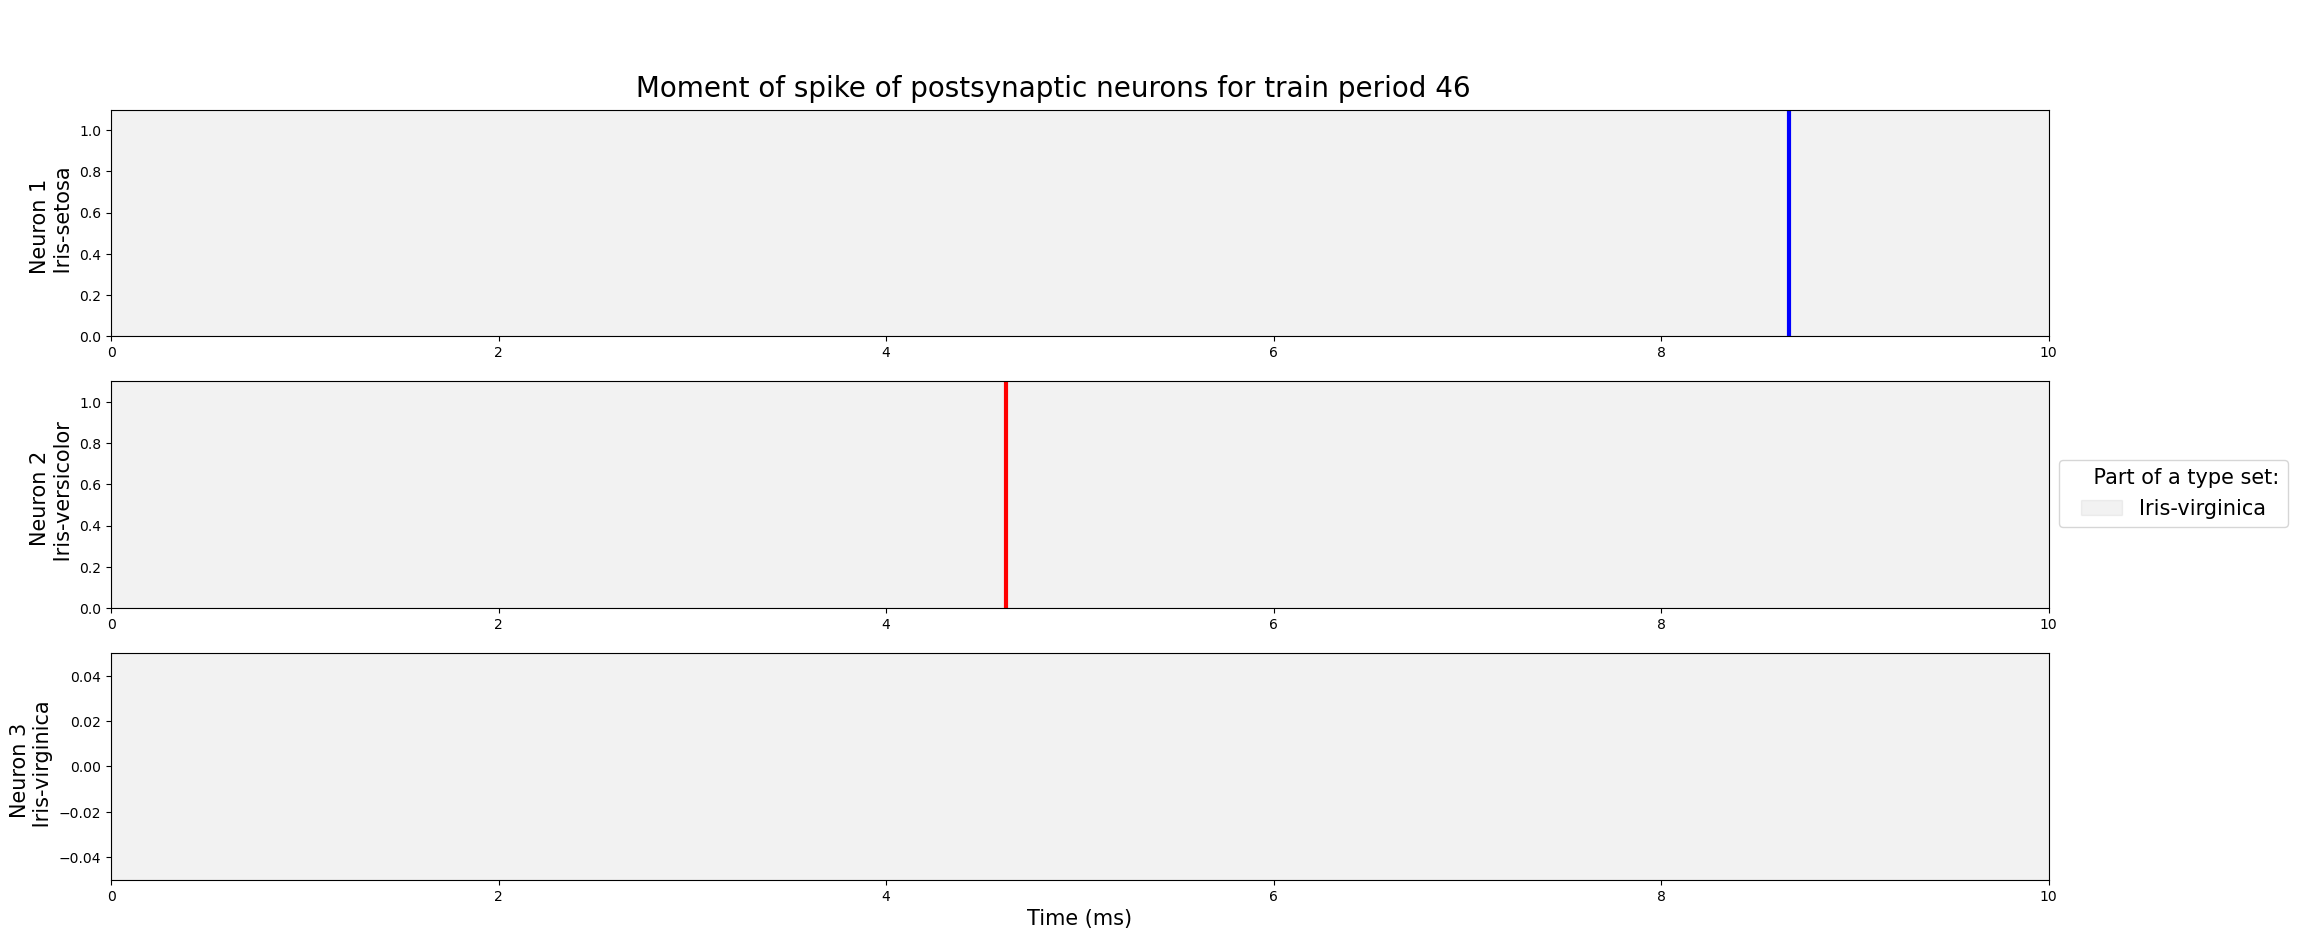

In [11]:
spike_plot(spike_time, True, 46, 3)

Together with the first incorrect spike, the second postsynaptic neuron spikes falsely, while the necessary third neuron remains silent. In this case, the second neuron will be recognized as having fired because it generated a spike earlier than the first - this is an error that reduces accuracy.

Let's examine the second false spike of the third postsynaptic neuron, which occurs in period 24 of the first part of training:

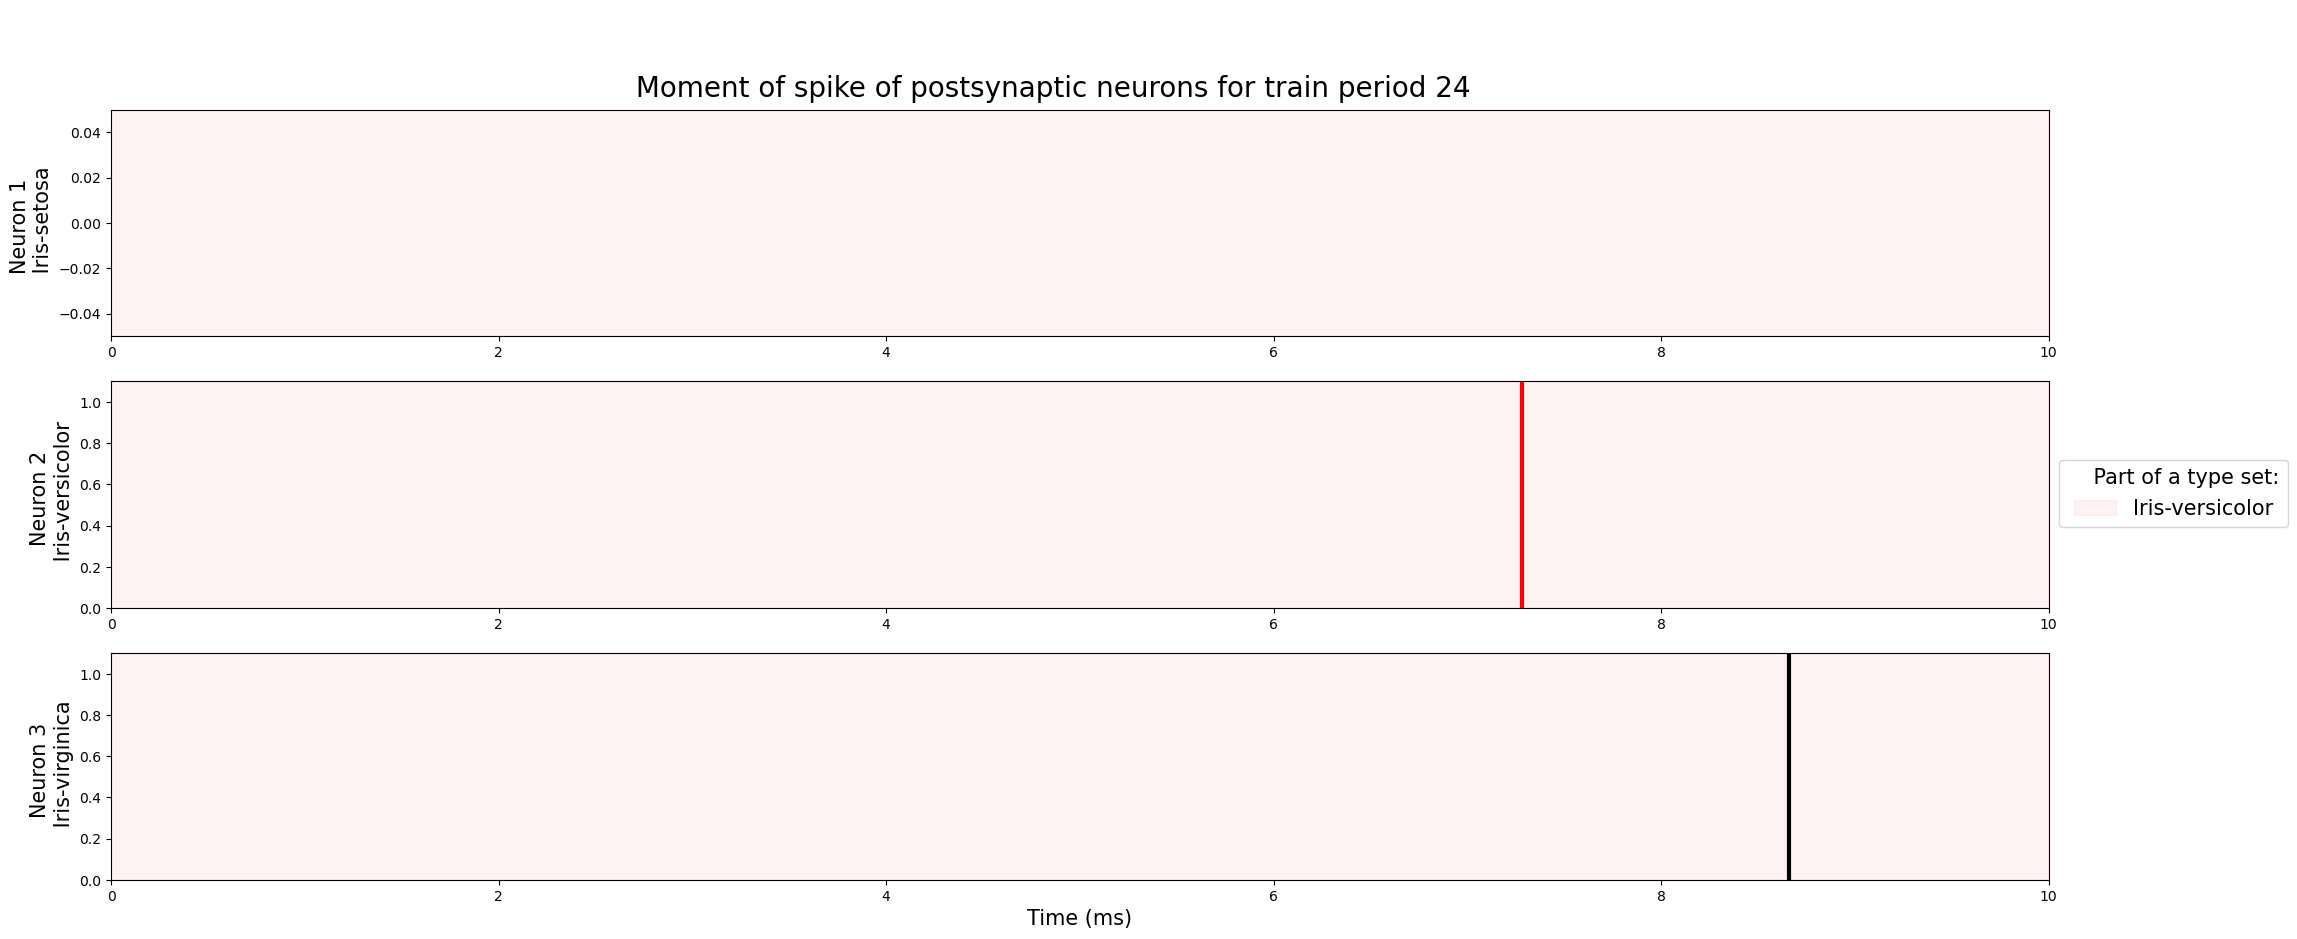

In [12]:
spike_plot(spike_time, True, 24, 2)

Together with the third spike in this period, the "correct" second postsynaptic neuron fires. In this case, because the second neuron fired earlier than the false third neuron, it will be considered as having fired in the current period and no error will occur.

Overall, things are going well, so let's smoothly transition to the second part of training. To do this, we take the next 20 examples of each type:

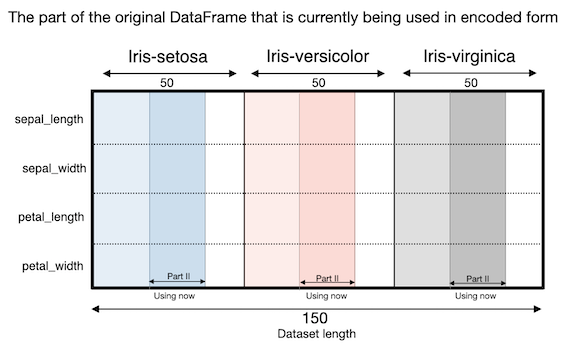

At this stage, we are training on the next set of input data using local STDP learning. Before we proceed, let's see what the result and accuracy would be if we applied the current weights to the second training set:

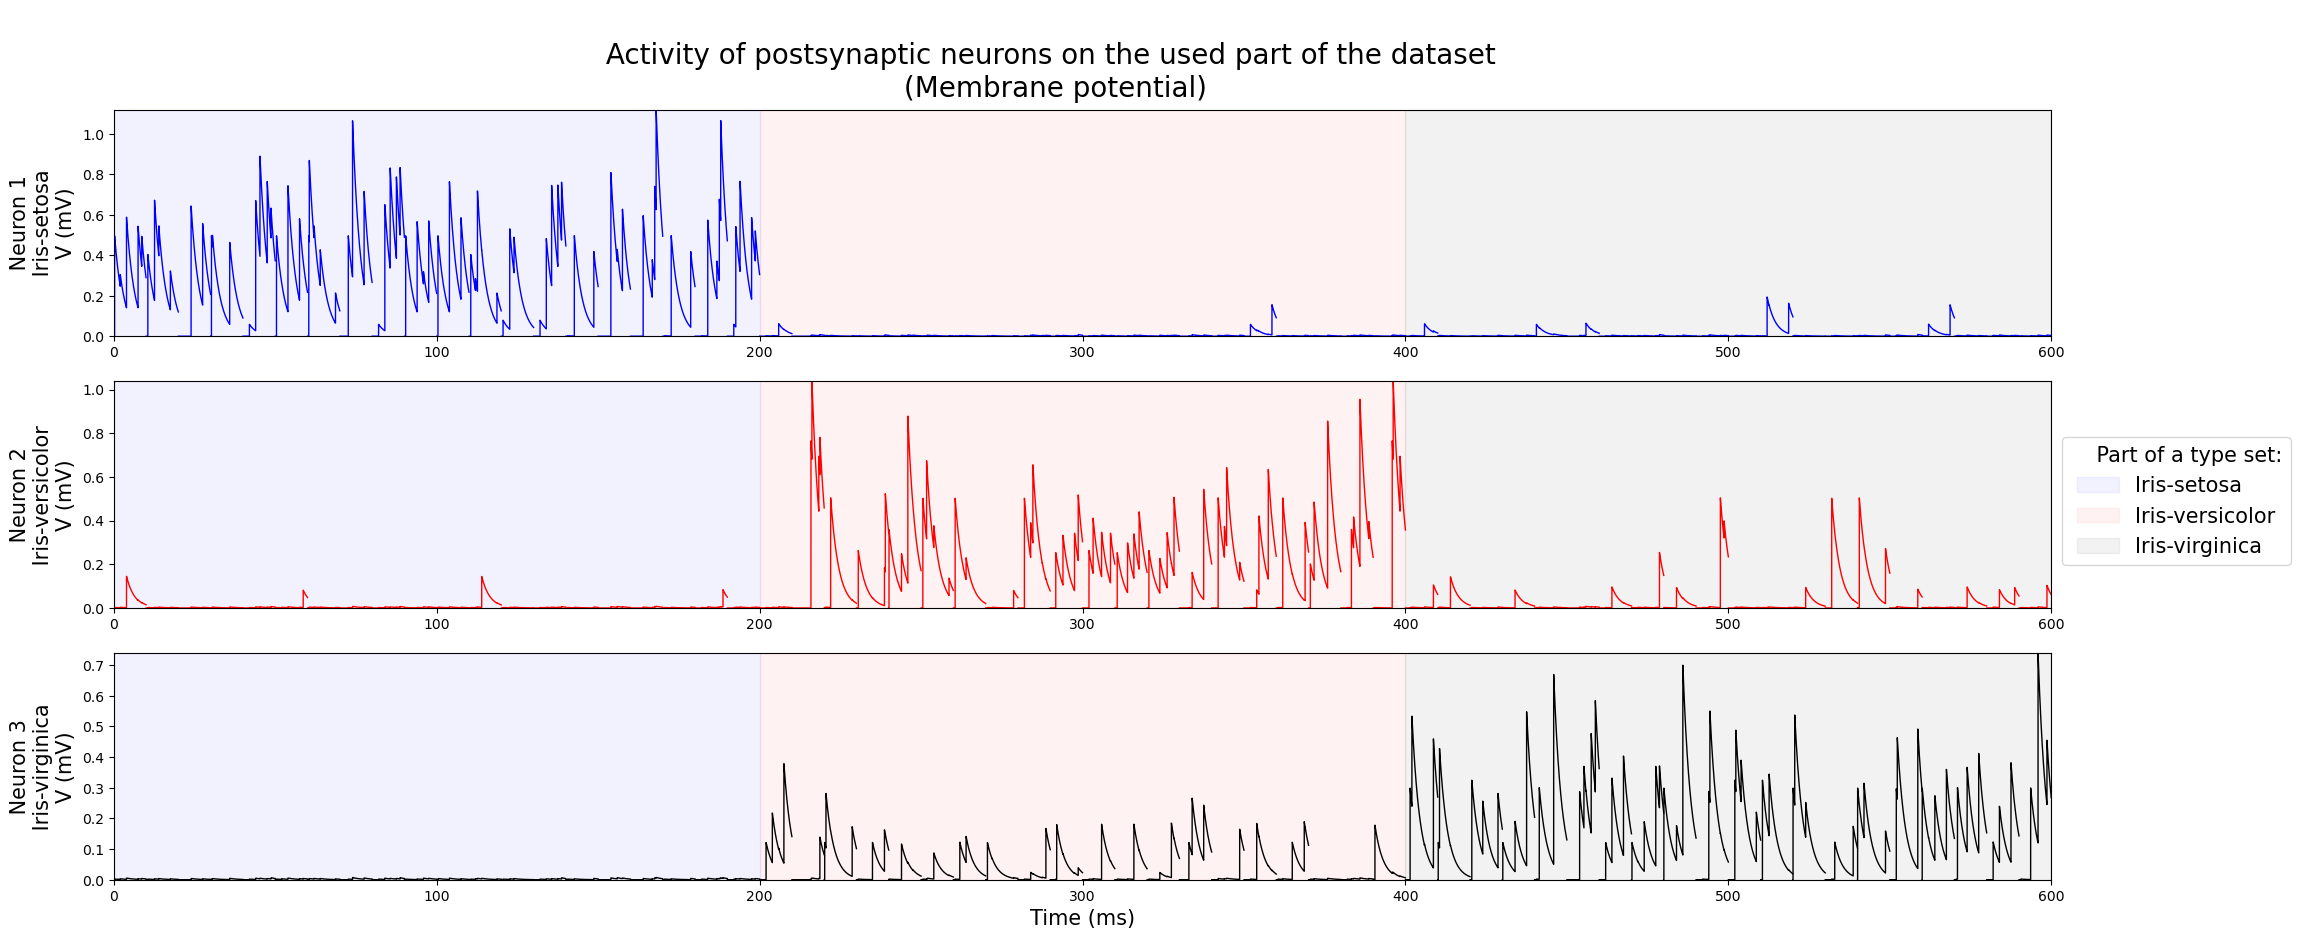

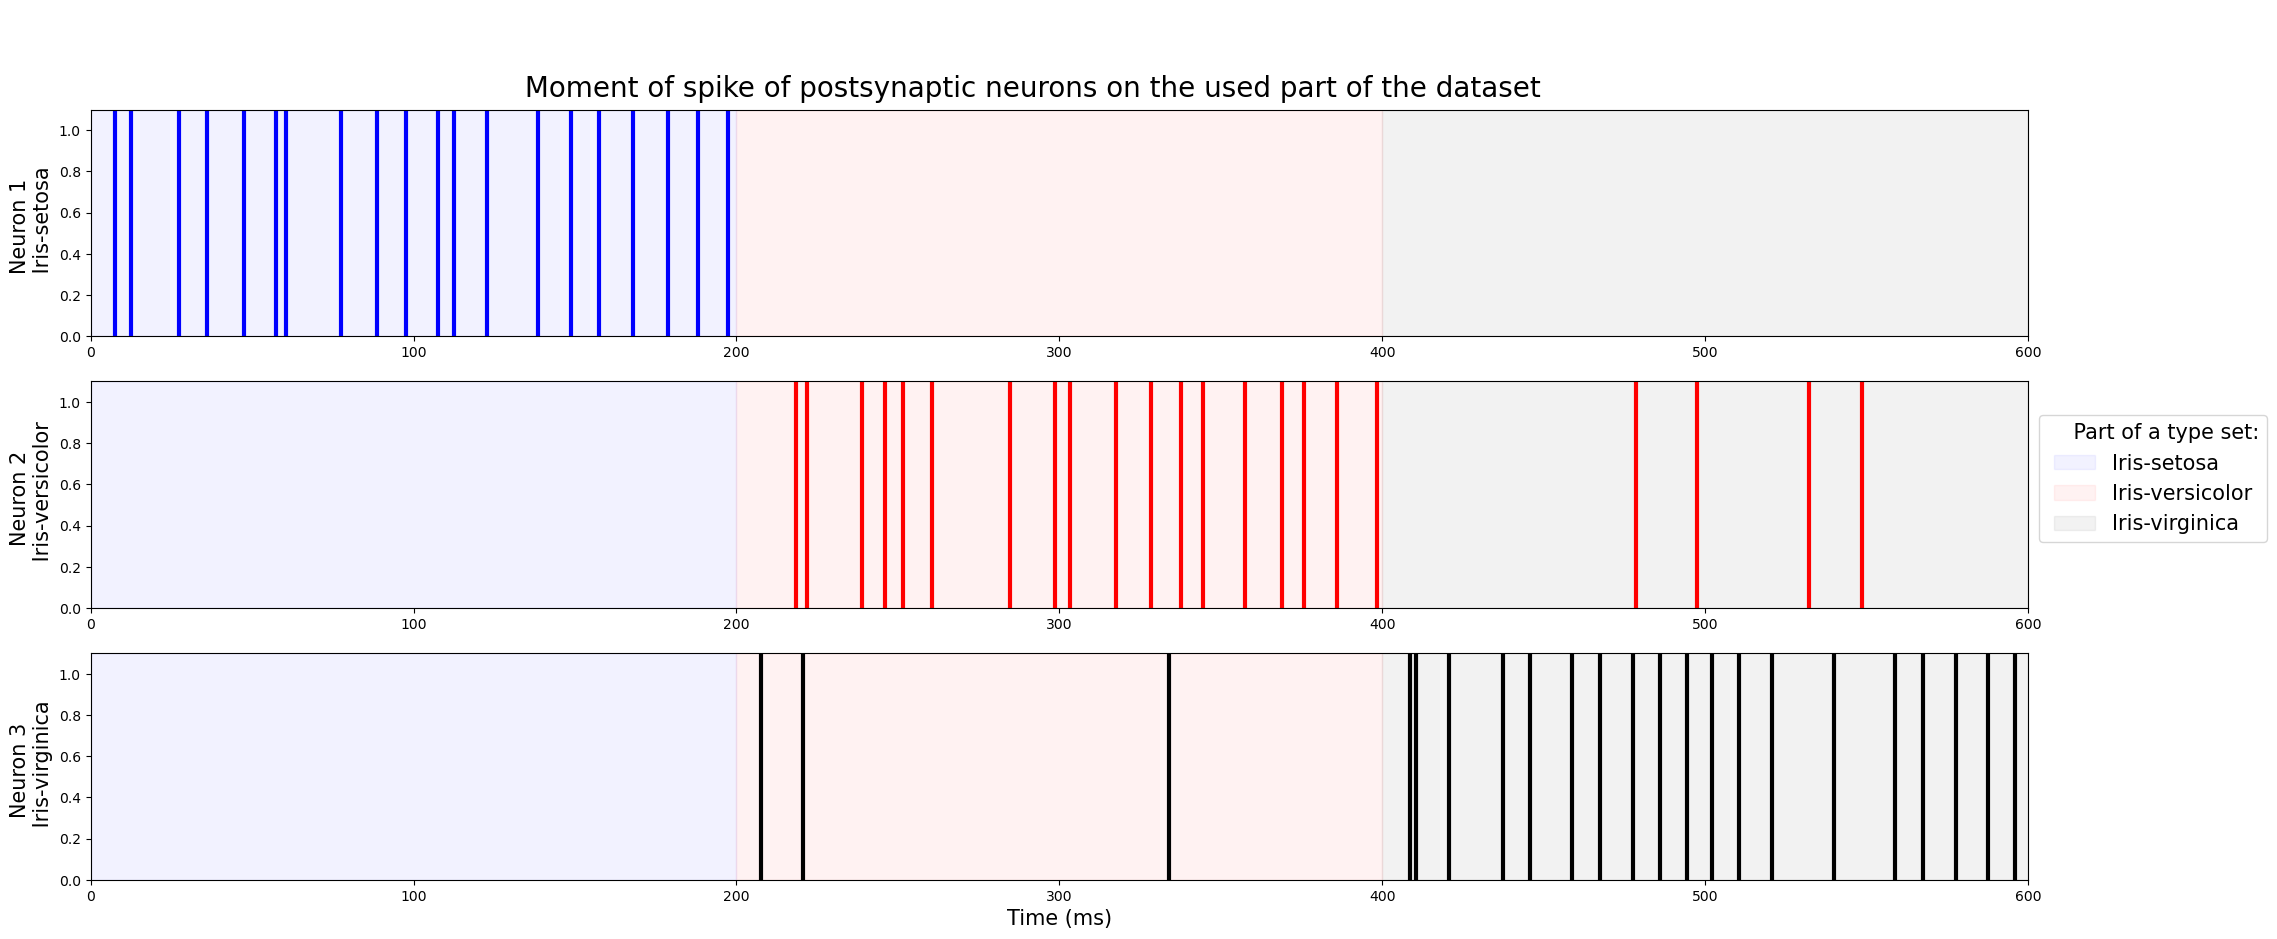

accur.: 91.67 %


In [13]:
train_stack = model_data(0, ind_type, lat_ne, 20, 40)
res = LIF_SNN(3, 60, train_stack, list_weight, 100)
v = res[0]

v_plot(v)
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 20, 40, ind_type, 0)[2]

Overall, the profile is similar to the profile of the first set. The accuracy has slightly decreased - a expected result.

Now it's time to adjust the weights using classical STDP for the second part of the training set. A few words about the formula and meaning of the used STDP approach. In short: presynaptic neurons generate spikes -> the membrane potential of the postsynaptic neuron increases and reaches a threshold value -> the postsynaptic neuron generates a spike -> if the period has not ended, presynaptic neurons can continue to generate spikes that are no longer needed -> it is necessary to strengthen the weights of presynaptic neurons that fired before the postsynaptic neuron generated a spike and decrease the weights of those that fired after.

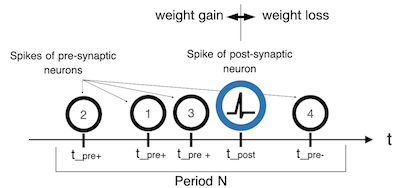

To apply STDP, we will record the spike timings of each postsynaptic neuron at a threshold value of 0.25, obtaining values for t_post. We already have the values for t_pre (latency) which we calculated earlier. We will calculate the weight change for each presynaptic neuron for each postsynaptic neuron using the following formulas:

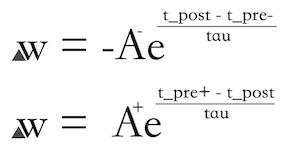

Depending on the presynaptic neuron's latency their the weights will be adjusted towards growth or reduction. The constants A+ and A- are selected individually for each task: if the training set is large, a small value can be chosen, and vice versa for a small training set (as we have now). A+ and A- are usually expressed in terms of each other:

In [14]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
t_post = res[1]
A_p = 0.8
A_m = A_p * 1.1

for n in range(3):
    for u in range(20):
        
        t1 = np.round(train_stack[u + 10 * n] * 1000)
        t2 = t1.copy()
        
        t2[((t1 <= t_post[n, u]) & (t1 > 0))] = A_p * np.exp((t1[((t1 <= t_post[n, u]) & (t1 > 0))] - t_post[n, u]) / 1000)
        t2[((t1 > t_post[n, u]) & (t1 > 0))] = - A_m * np.exp((t_post[n, u] - t1[((t1 > t_post[n, u]) & (t1 > 0))]) / 1000)
        
        list_weight[n, :] += t2
        
list_weight[list_weight < 0] = 0
list_weight

array([[ 6.86283594, 13.14555881, 11.21855962,  0.        ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.        ,  3.46874653,
         8.10106089,  5.35787327,  9.09420293,  4.99738161,  5.91379042,
        12.86232196, 35.28699568,  0.        ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        29.42315812, 33.23163288,  0.8992004 ,  0.1       ,  0.1       ,
         0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ],
       [ 0.84666134,  0.        ,  0.        ,  6.74229608,  2.22163186,
         3.82569237,  6.03148173,  0.1       ,  0.1       ,  0.1       ,
         8.02471674, 10.06988848,  0.89146427,  2.4844071 ,  0.        ,
         0.        ,  0.        ,  0.1       ,  1.19098518,  0.87791069,
         0.        ,  0.        ,  0.1       ,  6.75899905, 12.25004938,
        19.51810541,  2.64238288,  0.1       ,  0.

We have adjusted the weights, let's see how the accuracy of the model has now changed on the second set of training instances:

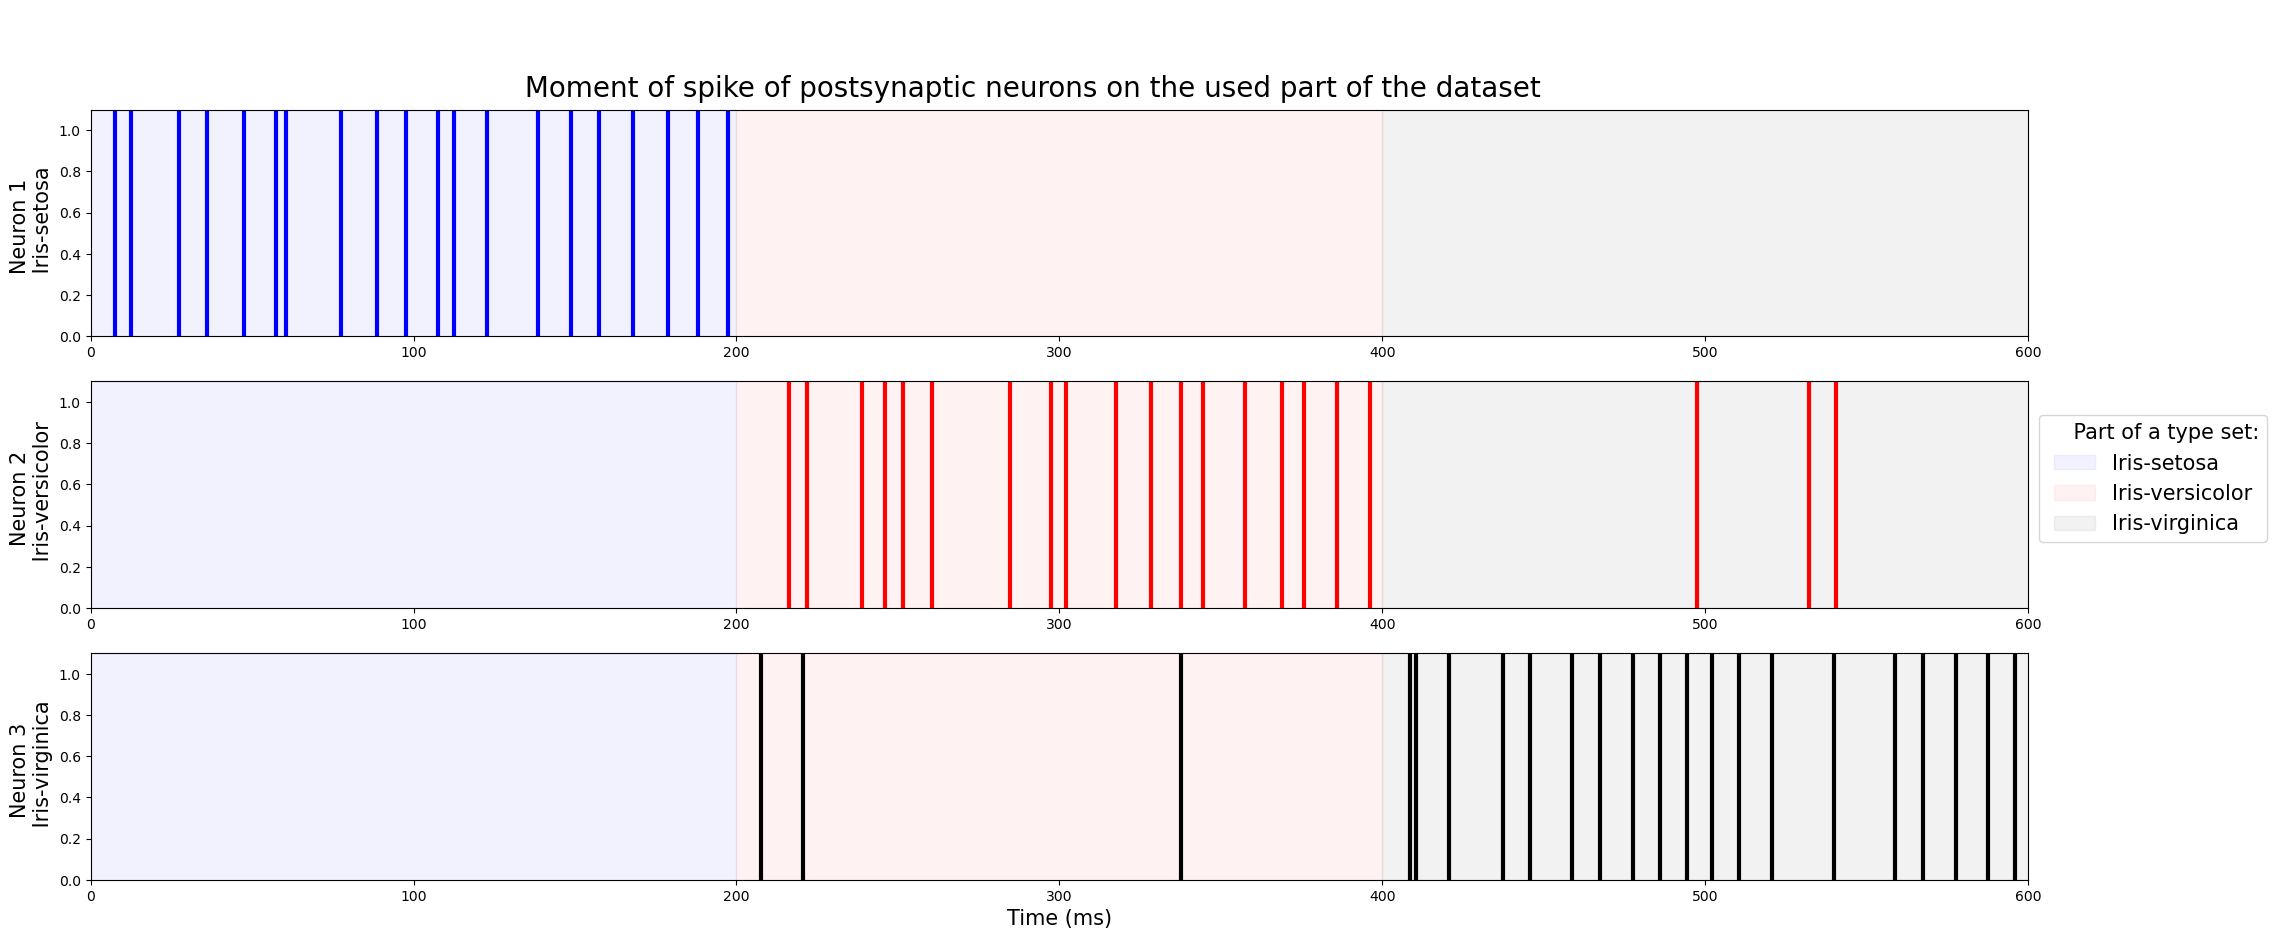

accur.: 93.33 %


In [15]:
res = LIF_SNN(3, 60, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 20, 40, ind_type, 0)[2]

Great! It has increased to its previous level. Now let's check the classification accuracy on the entire training set (all first 40 instances of each class) using by this weights:

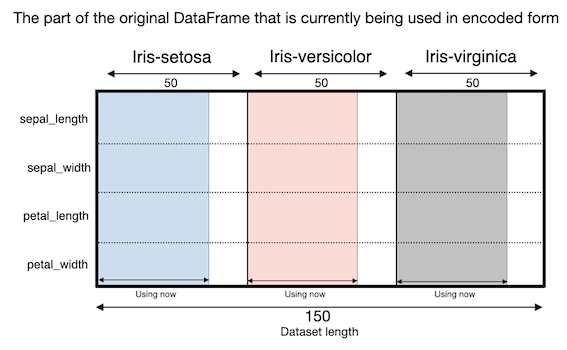

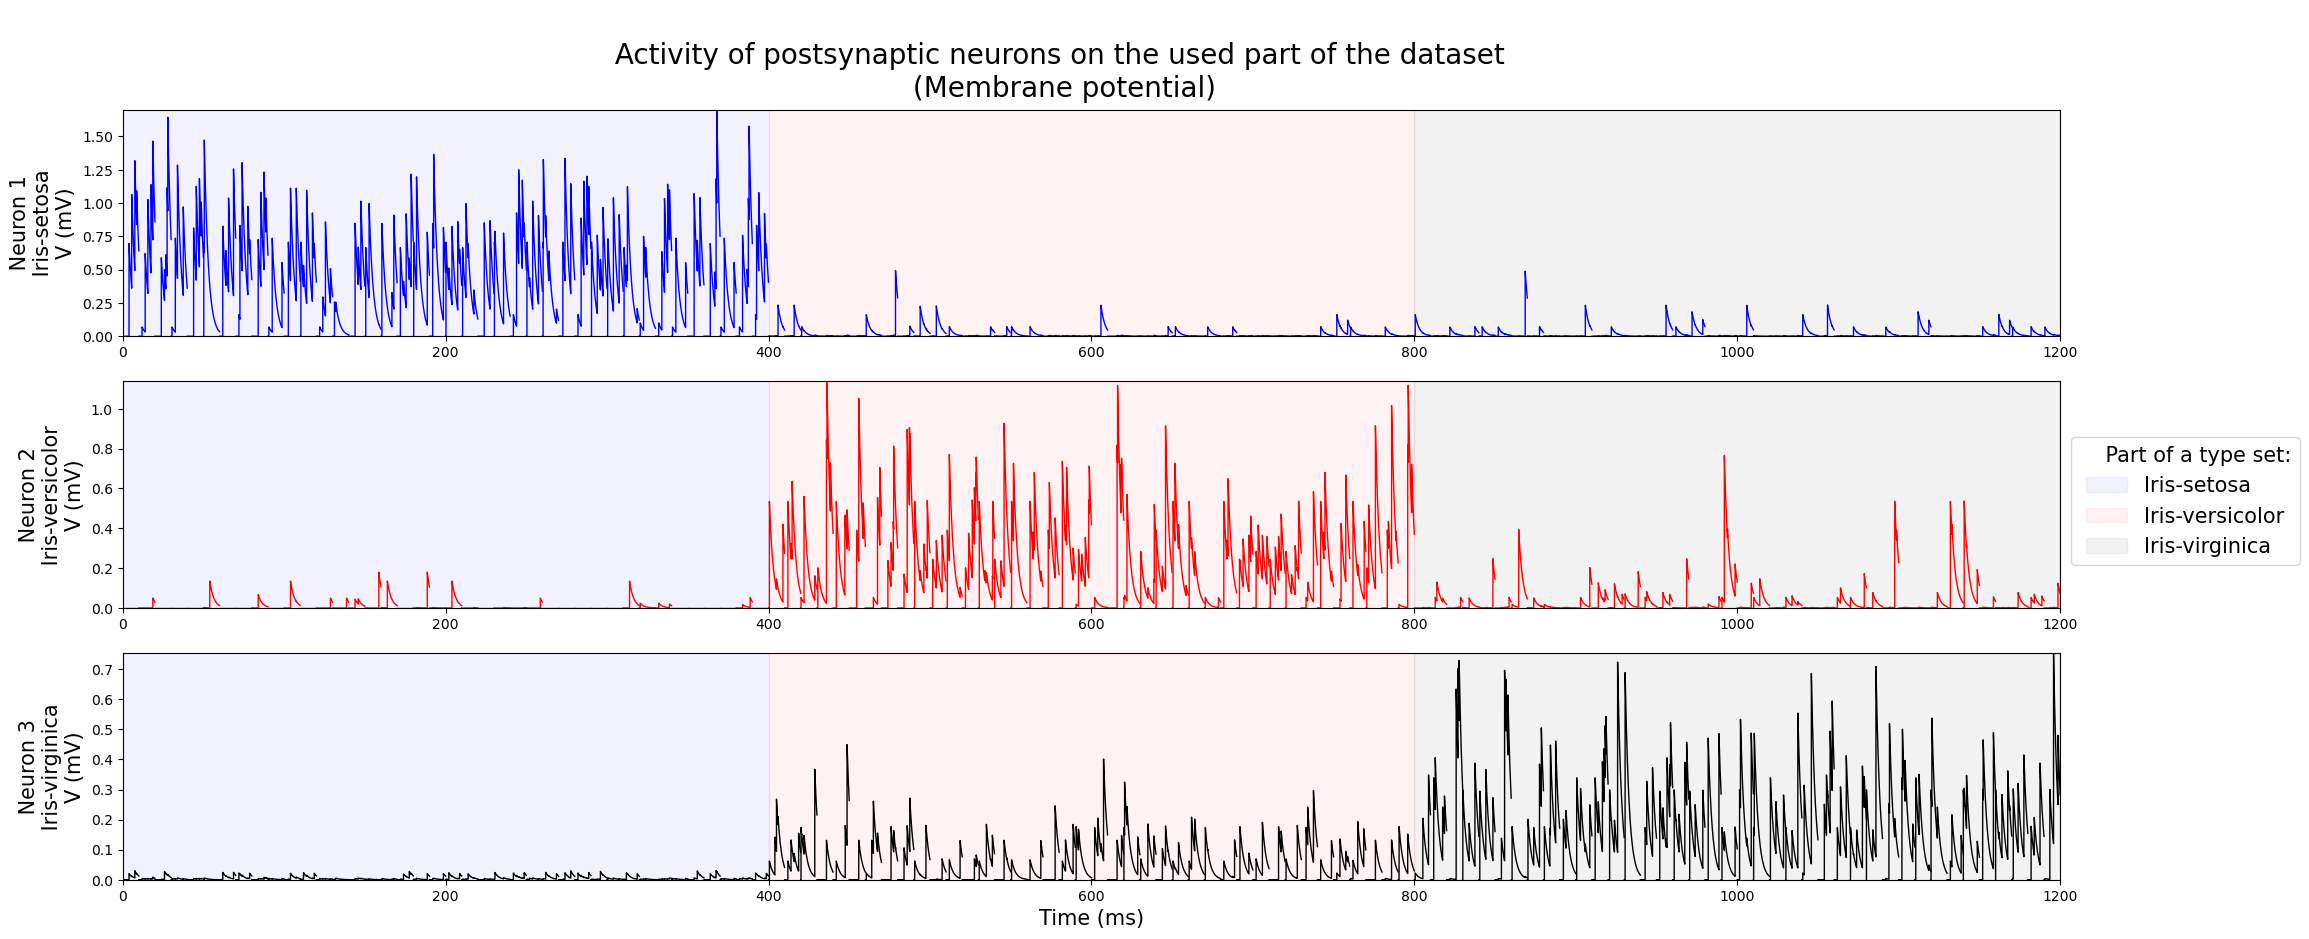

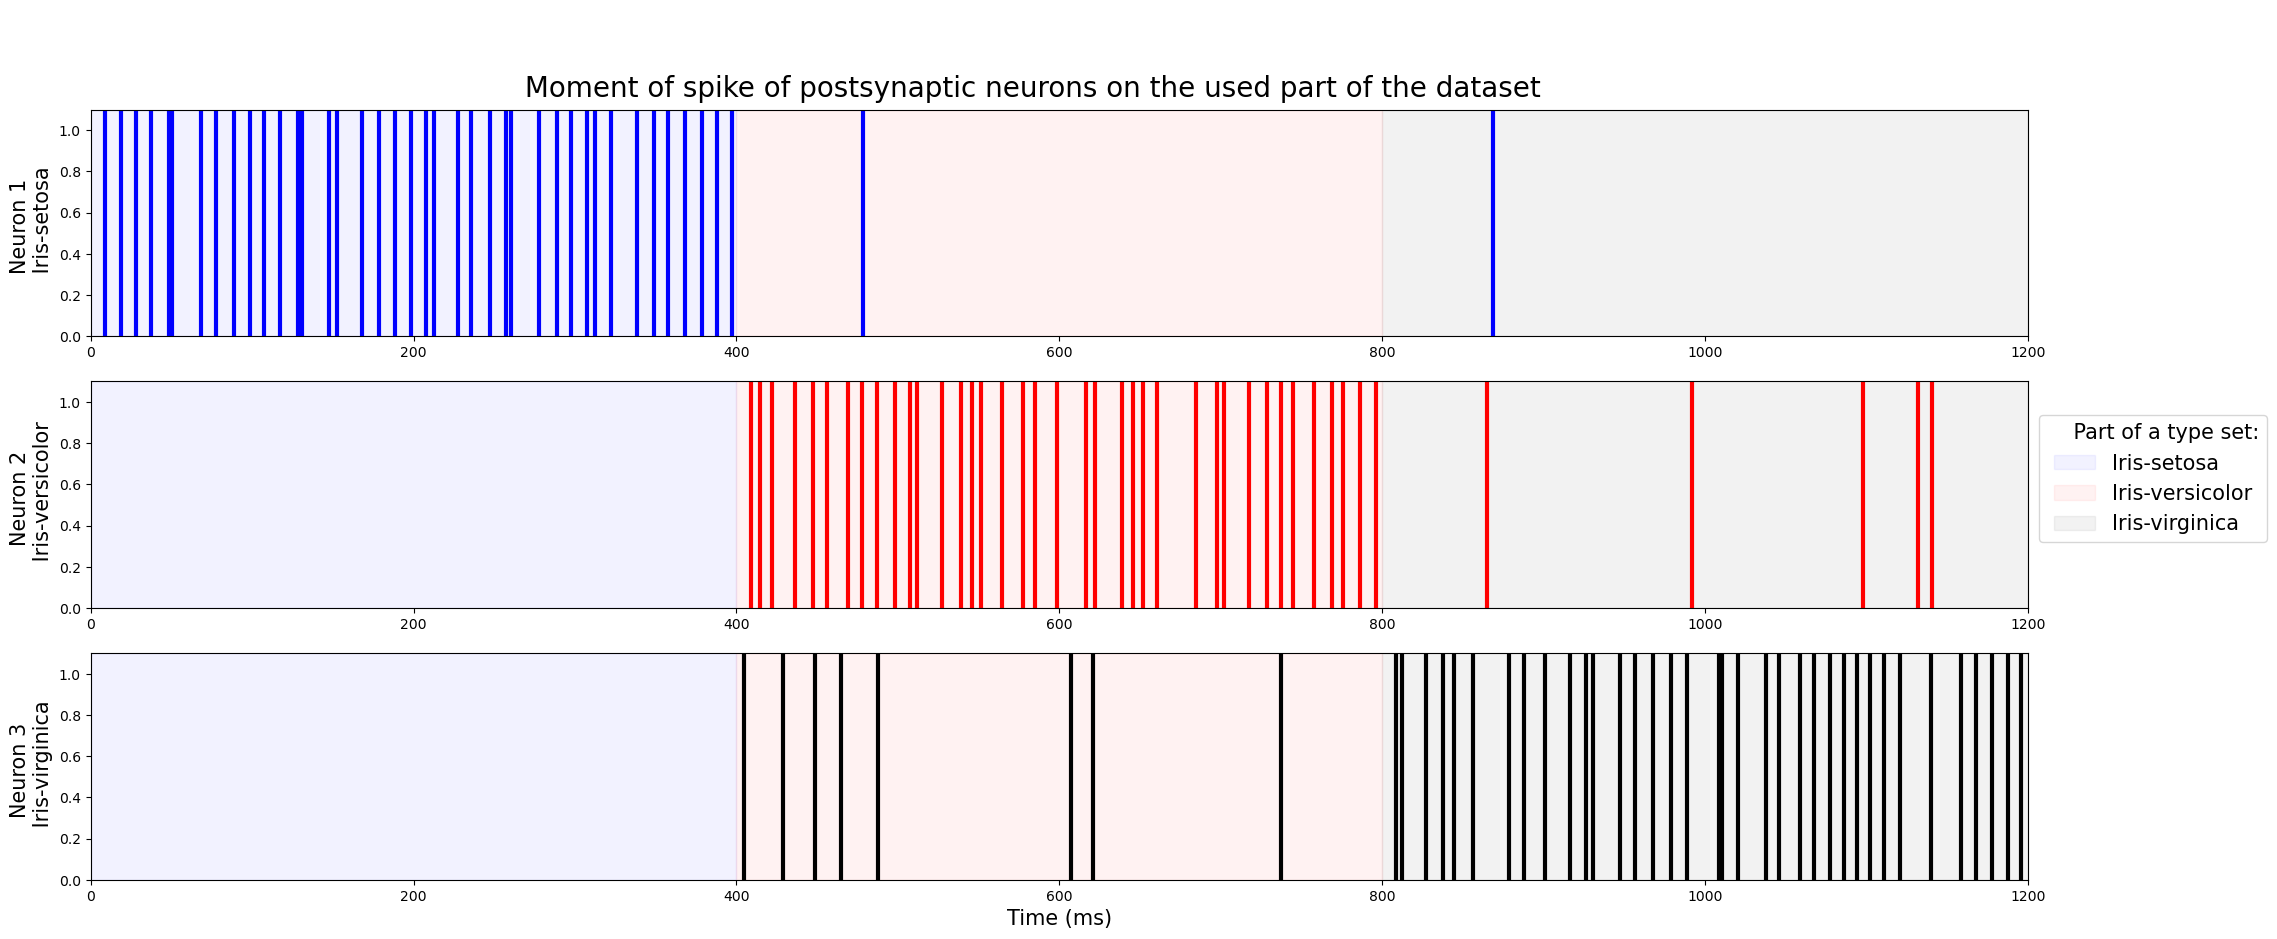

accur.: 92.5 %


In [16]:
train_stack = model_data(0, ind_type, lat_ne, 0, 40)
res = LIF_SNN(3, 120, train_stack, list_weight, 100)
v = res[0]

v_plot(v)
res = LIF_SNN(3, 120, train_stack, list_weight, 0.25)
spike_time = res[2]
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 0, 40, ind_type, 0)[2]

Overall, it's very good that the quality almost didn't decrease when the sample size was doubled. Although there are periods in which postsynaptic neurons sometimes fire at the wrong times, we still achieve high accuracy because the postsynaptic neuron that generated a spike earlier within one period is recognized as having fired.

Now let's run the network on the test set (the last 10 instances of each class):

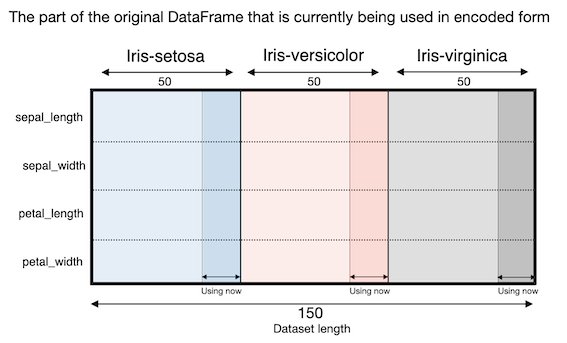

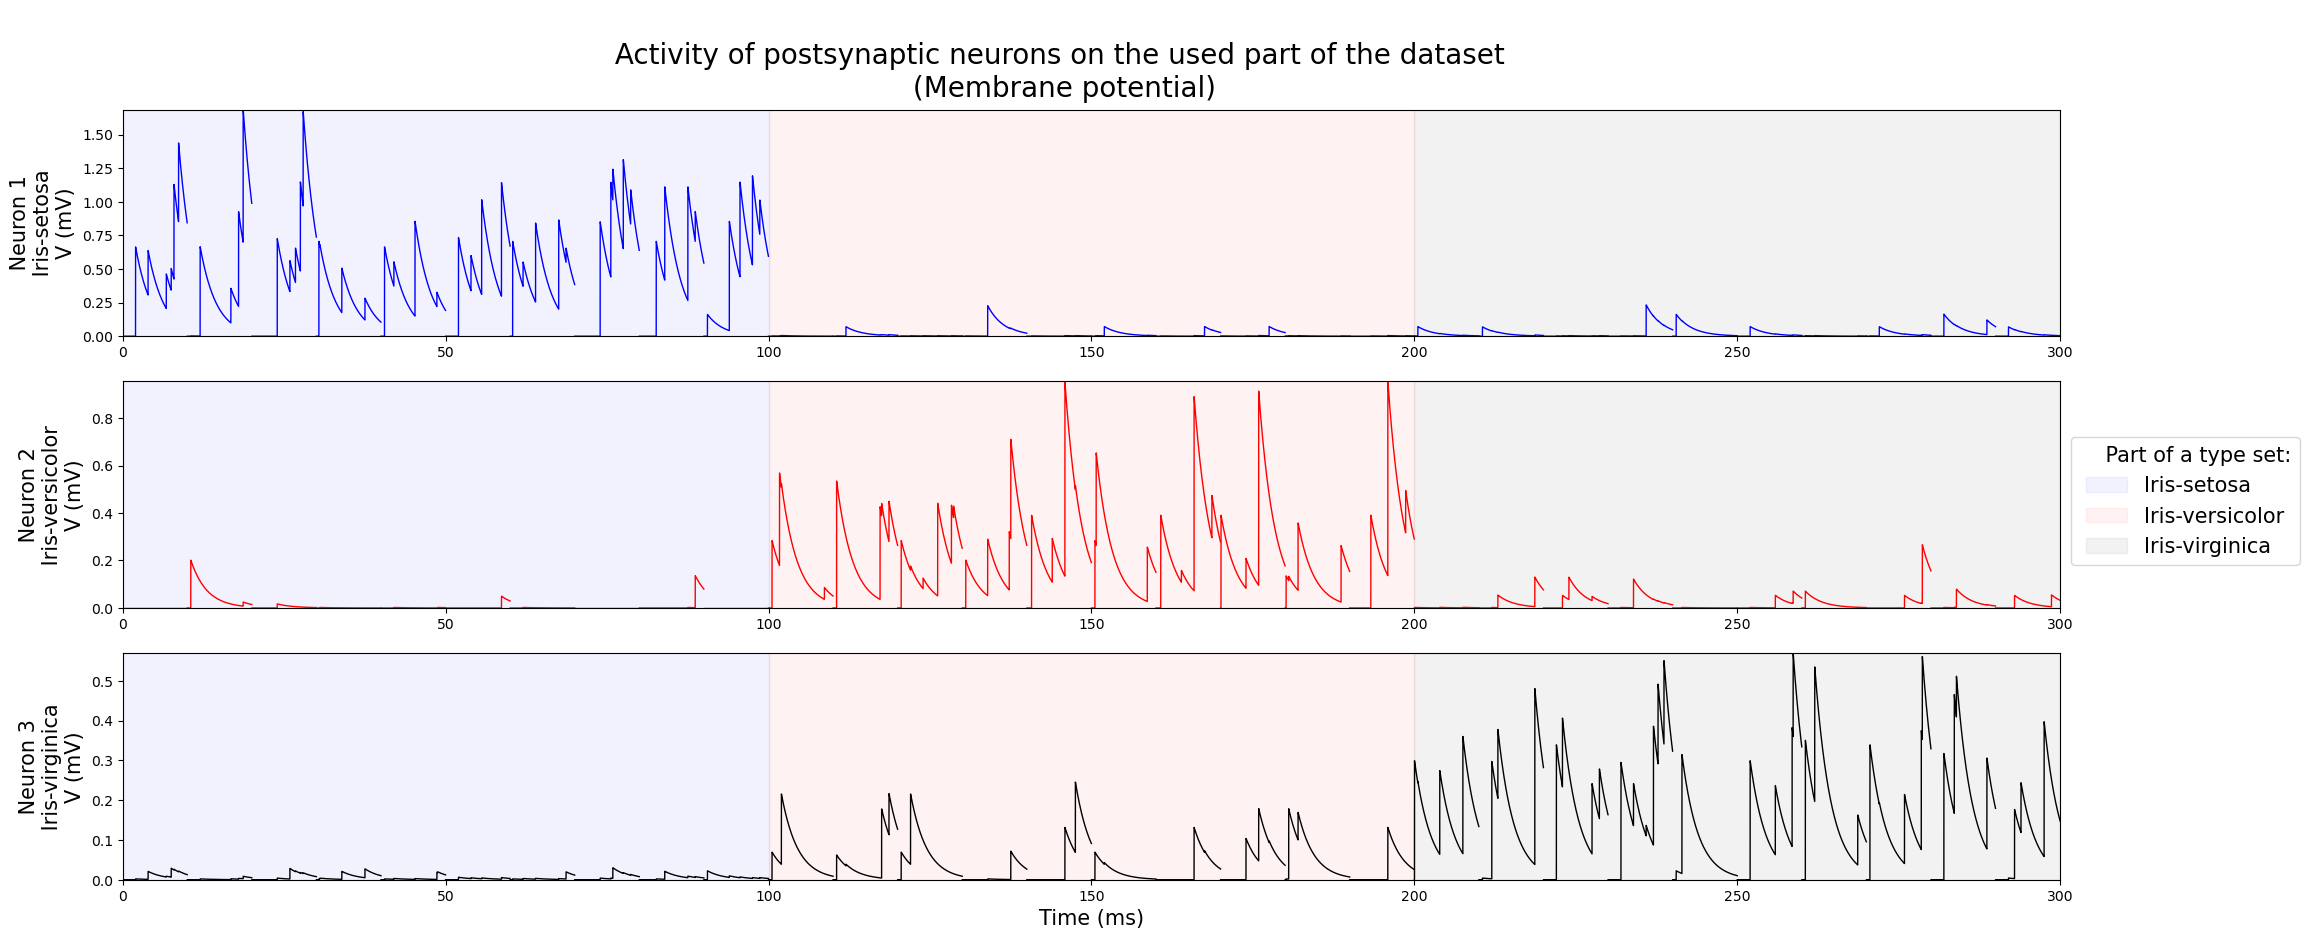

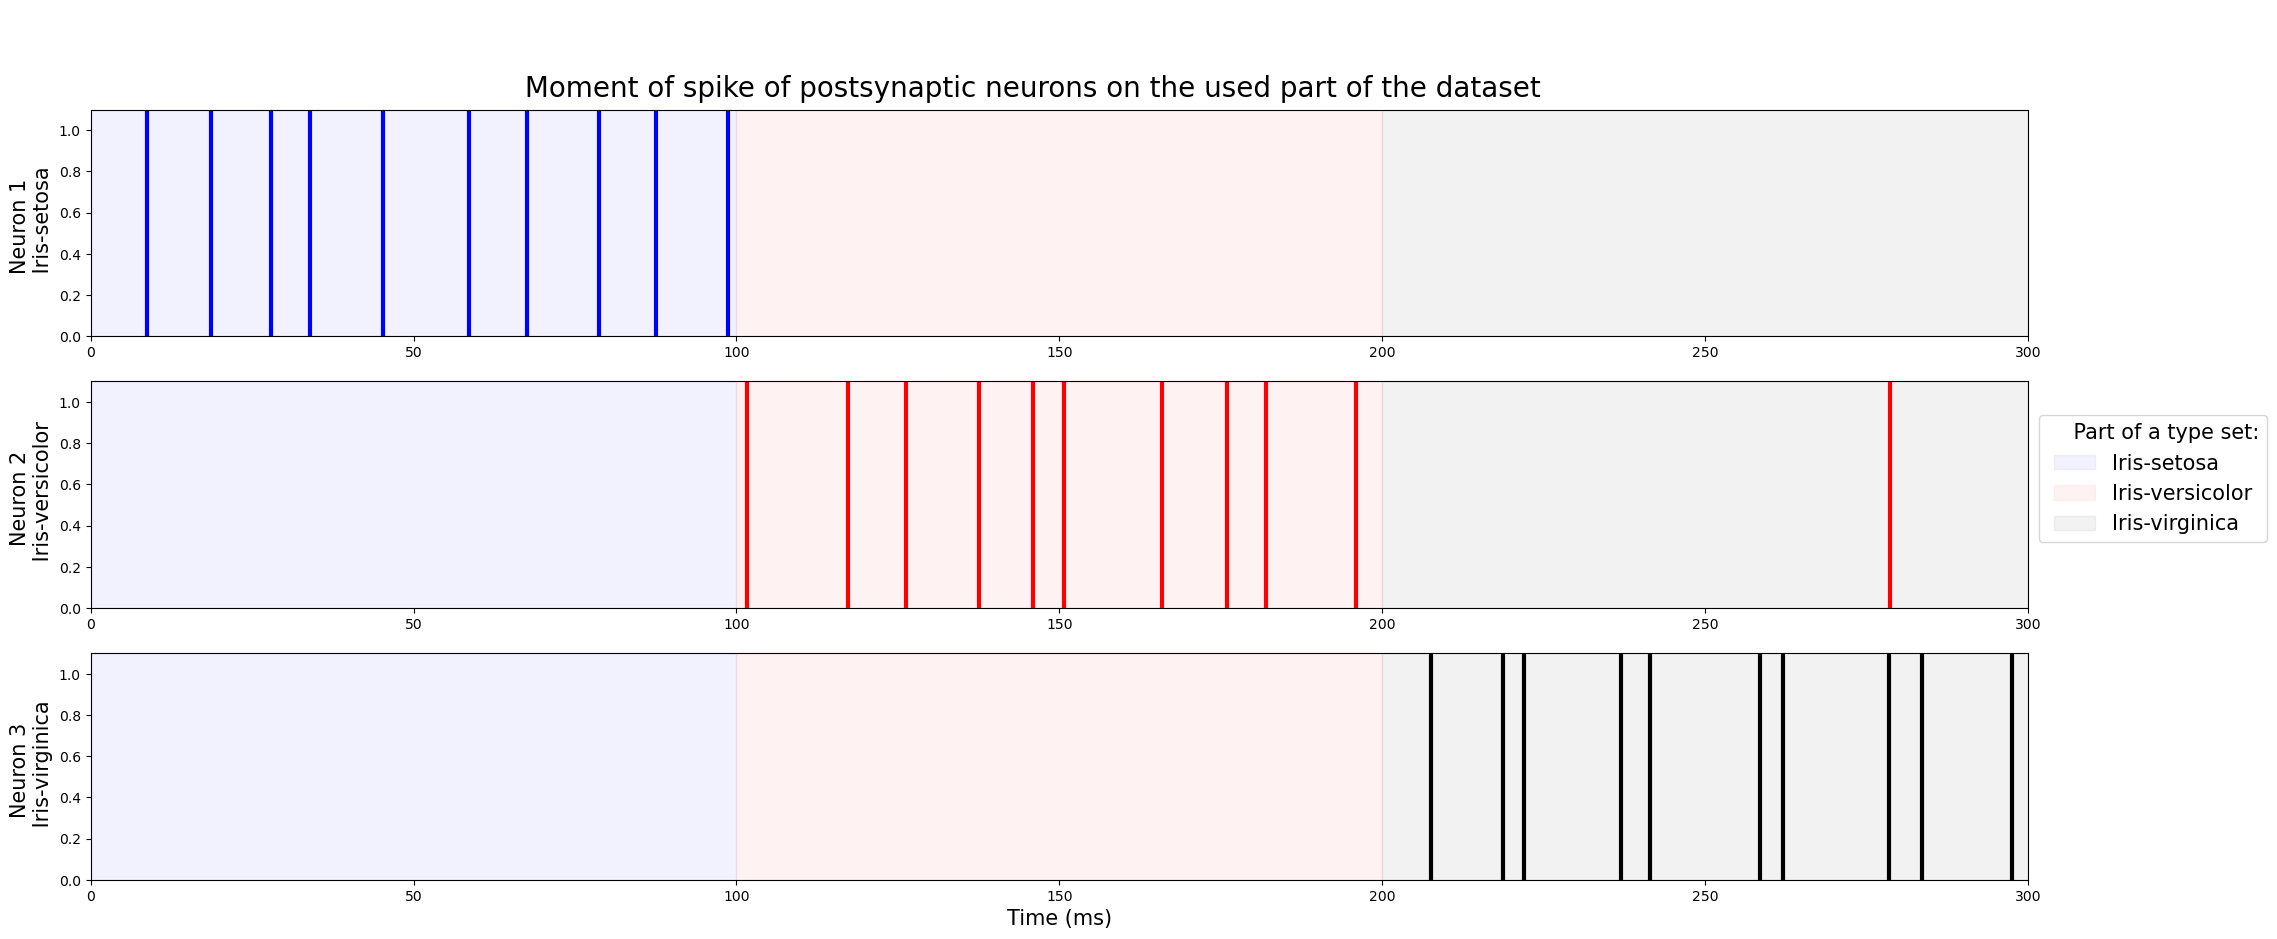

accur.: 100.0 %


In [17]:
train_stack = model_data(0, ind_type, lat_ne, 40, 50)
res = LIF_SNN(3, 30, train_stack, list_weight, 100)
v = res[0]
res = LIF_SNN(3, 30, train_stack, list_weight, 0.25)
spike_time = res[2]

v_plot(v)
spike_plot(spike_time, False, False, False)
accuracy_snn(spike_time, 40, 50, ind_type, 0)[2]

Accuracy is 100%!

There seems to be one false firing of the second postsynaptic neuron in period 27, let's examine it more closely:

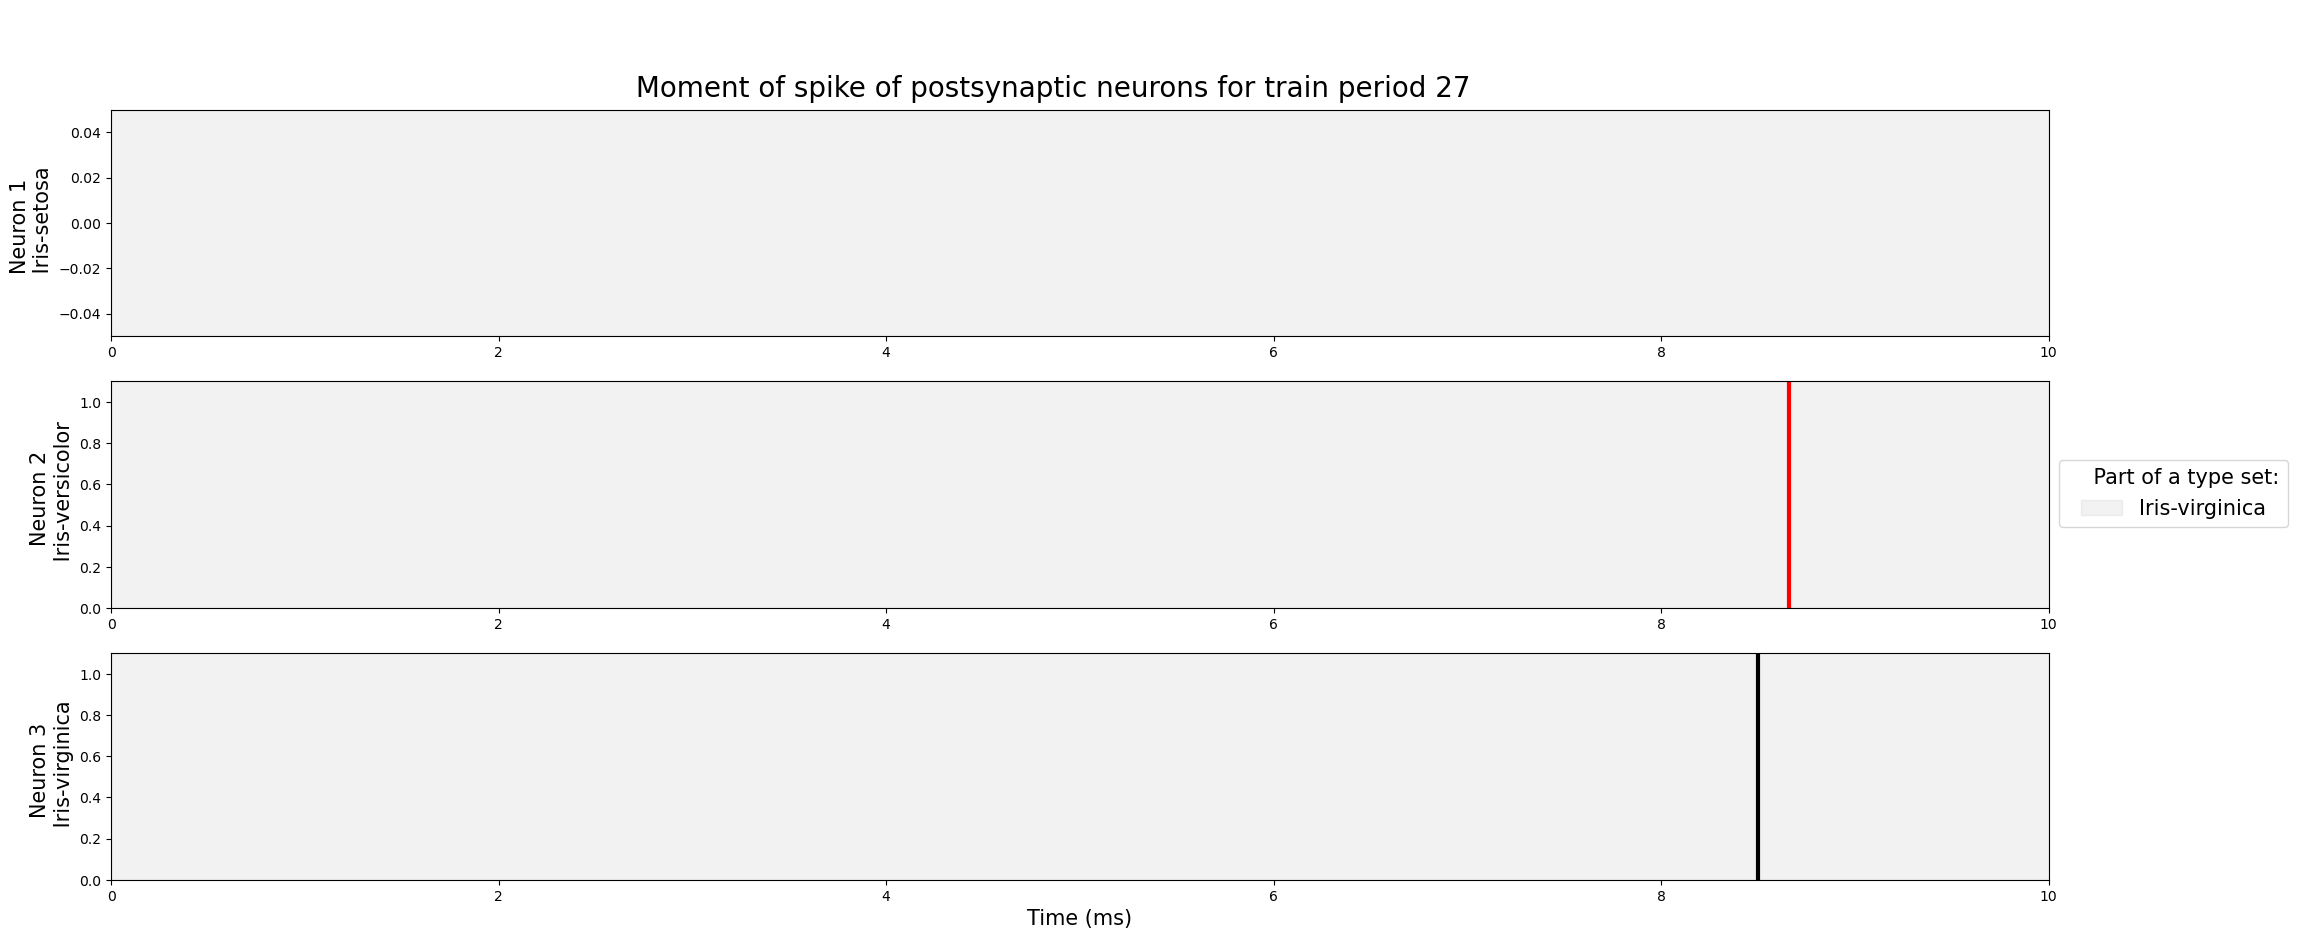

In [18]:
spike_plot(spike_time, True, 27, 3)

In this case, due to the fact that the third postsynaptic neuron fired before the false second one (8.50 mc vs 8.66 ms), it is considered to have fired in the current period and no error will occur.

Congratulations! we wrote a simple impulse neural model from scratch and learned how to encode data using Gaussian receptive fields using only NumPy.

**References**:

[1] Alexander Sboev, Danila Vlasov, Roman Rybka, Alexey Serenko, "[Spiking neural network reinforcement learning method based on Abstract temporal coding and STDP](https://www.sciencedirect.com/science/article/pii/S1877050918323950)", Procedia Computer Science Volume 145, 2018, Pages 458-463

[2] Stefan Schliebs, Nikola Kasabov, "[Evolving spiking neural networks: A Survey](https://www.researchgate.net/publication/257786595_Evolving_spiking_neural_networks_A_Survey)", Article in Evolving Systems, June 2013 DOI: 10.1007/s12530-013-9074-9

[3] M. Kiselev, "Spiking neural networks - Information Representation, Learning, Memory" (manuscript)

[4] Eugene M. Izhikevich, "[Simple Model of Spiking Neurons](https://www.izhikevich.org/publications/spikes.pdf)", IEEE TRANSACTIONS ON NEURAL NETWORKS, VOL. 14, NO. 6, NOVEMBER 2003

[5] Dmitry Ivanov, Aleksandr Chezhegov, Mikhail Kiselev, Andrey Grunin, Denis Larionov, "[Neuromorphic artificial intelligence systems](https://www.frontiersin.org/articles/10.3389/fnins.2022.959626/full)", Front. Neurosci., 14 September 2022, Sec. Neuromorphic Engineering, Volume 16 - 2022

[6] Laurent U Perrinet, Arnaud Delorme, Manuel Samuelides, Simon Jonathan Thorpe, "[Networks of Integrate-and-Fire Neuron using Rank Order Coding A: How to Implement Spike Time Dependent Hebbian Plasticity](https://www.researchgate.net/publication/220551941_Networks_of_Integrate-and-Fire_Neuron_using_Rank_Order_Coding_A_How_to_Implement_Spike_Time_Dependent_Hebbian_Plasticity)", June 2001, Neurocomputing 38-40:817-822, DOI:10.1016/S0925-2312(01)00460-X

[7] Senglan Li, Qiang Yu, "[New Efficient Multi-Spike Learning for Fast Processing and Robust Learning](https://www.researchgate.net/publication/342543443_New_Efficient_Multi-Spike_Learning_for_Fast_Processing_and_Robust_Learning)", April 2020Proceedings of the AAAI Conference on Artificial Intelligence 34(04):4650-4657, DOI:10.1609/aaai.v34i04.5896

[8] Gütig R, Sompolinsky H., "[The tempotron: a neuron that learns spike timing-based decisions](https://pubmed.ncbi.nlm.nih.gov/16474393/)", Nat Neurosci. 2006 Mar;9(3):420-8. doi: 10.1038/nn1643. Epub 2006 Feb 12. PMID: 16474393.

[9] Baktash Babadi, L. F. Abbott, "[Stability and Competition in Multi-spike Models of Spike-Timing Dependent Plasticity](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004750)", Published: March 3, 2016, https://doi.org/10.1371/journal.pcbi.1004750

[10] [Neuromatch Academy: Computational Neuroscience](https://compneuro.neuromatch.io/tutorials/intro.html)